# Simulation validation of `multidms` models

### Overview


The bloom lab developed a [pipeline to simulate DMS data](https://jbloomlab.github.io/dms_variants/codonvariant_sim_data.html) to test `dms_variants` global epistasis fitting. Here, we build upon the pipeline by simulating data for two homologs, introducing shifts in mutational effects at a subset of sites, with the goal of fitting and validating the `multidms` joint-fitting approach to recover those shifts.

This notebook has 3 major steps involved:

1. Simulate sequences and mutational effects for two homologs, introducing shifts at a subset of sites
2. Defines replicate libraries of variants, Simulating pre, and post-selection library variant counts through a bottleneck, then computing functional scores as noisy target for fitting.
3. multidms fitting and model and evaluation/selection.

## Setup for Analysis

### Import `Python` modules


For this analysis, we'll be using the `dms_variants` package for simulation. All dependencies needed can be installed by cloning the `multidms` repo and executing the command:

```
$ pip install '.[dev]'
```

In [38]:

import warnings
import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import Bio.Seq
import itertools
import random
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP, AAS_NOSTOP, AA_TO_CODONS, AAS_WITHSTOP
from plotnine import *
import multidms


In [4]:
warnings.simplefilter("ignore")
sns.set_theme(style='ticks', font_scale=1.5, palette='colorblind')

### Define notebook parameters


Set parameters that define the simulated data. Except for that fact that we use a short gene to reduce the computational run-time of this notebook, these simulation parameters are designed to reflect what we might observe in a real Bloom lab deep mutational scanning experiment:

In [41]:
# TODO, split this up between the different section where each parameter is actually relevant.
# For reproducibility, we set a random seed
seed = 24  # random number seed
random.seed(seed)
np.random.seed(seed)

# define the reference protein sequence we're going to simulate
genelength = 50  # gene length in codons
wt_latent = 5 # wildtype latent phenotype
min_observed_enrichment = 0.01
stop_effect = -15 # -15 is the default for `SigmoidPhenotypeSimulator` object - we found that

# define the non reference sequence attributes.
n_non_identical_sites = 10 # number of amino-acid mutations separating homologs
min_muteffect_in_bundle = -1 # minimum effect per mutation
max_muteffect_in_bundle = 1000 # maximum effect per mutation
n_shifted_non_identical_sites = 3 # number of non identical sites (in the bundle) for which mutations at that site are expected to have shifted effects
n_shifted_identical_sites = 5 # number of amino-acid mutations separating shifted
shift_gauss_variance = 1.5 # variance of the gaussian distribution from which the shifted effects are drawn

# define the libraries
libs = ["lib_1", "lib_2"]  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.0  # average codon mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.005  # rate at which variant sequence mis-called
avgdepth_per_variant = 200  # average per-variant sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.05

# define the selection TODO, make these simple scalar params
bottlenecks = {  # bottlenecks from pre- to post-selection
    "tight_bottle": variants_per_lib * 5,
    "loose_bottle": variants_per_lib * 100,
}

# model fitting parameters
fitting_params = {
    "iterations_per_step": [100], # default 20000
    "scale_coeff_lasso_shift": [0.0, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 3e-4], # the sweep of lasso coefficient params
    "init_beta_naught" : [5.0], # We've found that we need to start with a higher beta_naught to get the model to converge correctly
}

## Simulating sequences and phenotypes

### Simulate a reference sequence


Start by simulating a sequence of nucleotides, then translate it to amino acids. We'll use this sequence as the reference sequence for the simulated datasets.

In [7]:
#genelength = 50  # gene length in codons
geneseq_h1 = "".join(random.choices(CODONS_NOSTOP, k=genelength))
aaseq_h1 = str(Bio.Seq.Seq(geneseq_h1).translate())
print(f"Wildtype gene of {genelength} codons:\n{geneseq_h1}")
print(f"Wildtype protein:\n{aaseq_h1}")

Wildtype gene of 50 codons:
GGTTCCAGTTTTAGTGGAACCGTGAGCGGTGTAGTGCGGTCGTTTACTCTTTTCGTCCGTCAGTTCACCGTGTCCAGCCATCAGGACCCGTGCTGTCATTGCACAACCGGATACTATTTTTCGCAAGTCTGTACCCTGAGCAGACTCGGA
Wildtype protein:
GSSFSGTVSGVVRSFTLFVRQFTVSSHQDPCCHCTTGYYFSQVCTLSRLG


### Mutational effects and phenotype function


Simulate latent mutational effects, $\beta_m$, and post-latent sigmoidal phenotype function, $g(z)$ for the first homolog, storing data in a `SigmoidPhenotypeSimulator` object. Also create an identical object for the second homolog. Later, we'll update this object to include shifted mutational effects.

In [8]:
mut_pheno_args = {
    "geneseq" : geneseq_h1,
    "wt_latent" : wt_latent,
    "seed" : seed,
    "stop_effect" : stop_effect,
    "min_observed_enrichment" : min_observed_enrichment
}

SigmoidPhenotype_h1 = dms_variants.simulate.SigmoidPhenotypeSimulator(**mut_pheno_args)
SigmoidPhenotype_h2 = dms_variants.simulate.SigmoidPhenotypeSimulator(**mut_pheno_args)

Plot the distribution of mutation effects for the first homolog.

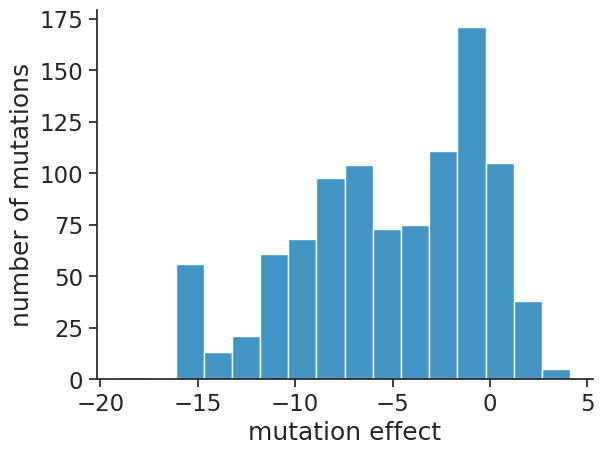

In [9]:
sns.histplot(SigmoidPhenotype_h1.muteffects)
plt.xlabel('mutation effect')
plt.ylabel('number of mutations')
sns.despine()
plt.show()

### Non-reference homolog sequence


Next, we'll simulate the DNA/protein sequence of second homolog by making a defined number of random amino-acid mutations to the first homolog. When choosing the "bundle" of mutation which separate the two homologs, we avoid mutations that decrease or increase the latent phenotype by more than `min_muteffect_in_bundle` and `max_muteffect_in_bundle` respectively. This is to ensure that the latent phenotype of the second homolog is not too different from the first homolog, an important assumption for the `multidms` model.

In [10]:
# Input params
non_identical_sites = sorted(random.sample(range(1, len(aaseq_h1)+1), n_non_identical_sites))
aaseq_h2 = ''
geneseq_h2 = ''


# Iterate over each amino acid in the first homolog, and make
# a mutation if indicated.
for (aa_n, aa) in enumerate(aaseq_h1, 1):
    codon = geneseq_h1[(aa_n-1)*3:3*aa_n]
    if aa_n in non_identical_sites:
        # define the valid mutations for this site
        valid_bundle_mutations = [
            mut_aa for mut_aa in AAS_NOSTOP
            if (
                (mut_aa != aa) \
                and (SigmoidPhenotype_h1.muteffects[f'{aa}{aa_n}{mut_aa}'] > min_muteffect_in_bundle) \
                and (SigmoidPhenotype_h1.muteffects[f'{aa}{aa_n}{mut_aa}'] < max_muteffect_in_bundle)
            )
        ]
        assert len(valid_bundle_mutations) > 0, aa_n
        mut_aa = random.choice(valid_bundle_mutations)
        aaseq_h2 += mut_aa
        mut_codon = random.choice(AA_TO_CODONS[mut_aa])
        geneseq_h2 += mut_codon
    else:
        aaseq_h2 += aa
        geneseq_h2 += codon

# Store and summarize results
homolog_seqs = {
    1 : aaseq_h1,
    2 : aaseq_h2
}
n_diffs = sum([aa1 != aa2 for (aa1, aa2) in zip(aaseq_h1, aaseq_h2)])
print('Sequence alignment of homologs h1 and h2:')
print('h1', aaseq_h1)
print('h2', aaseq_h2)
print('Number of aa differences:', n_diffs)
assert len(aaseq_h1) == len(aaseq_h2)
assert aaseq_h2 == str(Bio.Seq.Seq(geneseq_h2).translate())
assert n_diffs == len(non_identical_sites)

Sequence alignment of homologs h1 and h2:
h1 GSSFSGTVSGVVRSFTLFVRQFTVSSHQDPCCHCTTGYYFSQVCTLSRLG
h2 GSSFSGTWEGVVRHFTLFVRQFTVSSHQDPCRHCDTLMYFSGVETLSRVG
Number of aa differences: 10


### Shifted mutational effects

Next, randomly choose a subset of (identical and non-identical) sites that will have shifted mutational effects. Do this independently for sites that are identical and non-identical between homologs, so that we are sure to have shifted sites in each category.

In [11]:
# Non-identical sites
random.seed(seed)
shifted_non_identical_sites = sorted(random.sample(
    non_identical_sites,
    n_shifted_non_identical_sites
))

# Identical sites
identical_sites = [
    i for i in range(1, len(aaseq_h1)+1)
    if i not in non_identical_sites
]
shifted_identical_sites = sorted(random.sample(
    identical_sites,
    n_shifted_identical_sites
))

# Make a list of all shifted sites
shifted_sites = sorted(shifted_identical_sites + shifted_non_identical_sites)
assert len(shifted_sites) == len(set(shifted_sites))
print('Sites with shifts that are...')
print(f'identical (n={len(shifted_identical_sites)}):', ', '.join(map(str, shifted_identical_sites)))
print(f'non-identical (n={len(shifted_non_identical_sites)}):', ', '.join(map(str, shifted_non_identical_sites)))

Sites with shifts that are...
identical (n=5): 6, 12, 13, 16, 22
non-identical (n=3): 14, 32, 38


At each of the above sites, randomly simulate a shift in the effect of each mutation by drawing shifts from a Gaussian distribution.

In [12]:
# TODO possibly have different rate parameters for each site.
def sim_mut_shift(shifted_site, mutation):
    if (not shifted_site) or ('*' in mutation):
        return 0
    else:
        return np.random.normal(loc=0, scale=shift_gauss_variance, size=1)[0]

# Make a dataframe of mutation effects in the first homolog
mut_effects_df = pd.DataFrame.from_dict(
    SigmoidPhenotype_h1.muteffects,
    orient='index',
    columns=['beta_h1']
)
mut_effects_df.reset_index(inplace=True)
mut_effects_df.rename(columns={'index':'mutation'}, inplace=True)
mut_effects_df['wt_aa'] = mut_effects_df['mutation'].str.extract(r'([\w*])\d+[\w*]')
mut_effects_df['site'] = mut_effects_df['mutation'].str.extract(r'[\w*](\d+)[\w*]')
mut_effects_df['site'] = mut_effects_df['site'].astype(int)
mut_effects_df['mut_aa'] = mut_effects_df['mutation'].str.extract(r'[\w*]\d+([\w*])')

# Simulate shifts for all mutations in the pre-defined
# list of shifted sites, ignorning mutations to stop codons
mut_effects_df['shifted_site'] = mut_effects_df['site'].apply(
    lambda x: x in shifted_sites
)
np.random.seed(seed)
mut_effects_df['shift'] = mut_effects_df.apply(
    lambda row: sim_mut_shift(
        row['shifted_site'],
        row['mutation']
    ),
    axis=1
)

# Add column that gives mutation effects in the second homolog
mut_effects_df['beta_h2'] = mut_effects_df['beta_h1'] + mut_effects_df['shift']

# Add columns that give the wildtype amino acids of
# each homolog at each site
for (homolog, seq) in homolog_seqs.items():
    seq_dict = {
        key : []
        for key in ['site', f'aaseq_h{homolog}']
    }
    for (i, aa) in enumerate(seq, 1):
        seq_dict['site'].append(i)
        seq_dict[f'aaseq_h{homolog}'].append(aa)
    seq_df = pd.DataFrame.from_dict(seq_dict)
    mut_effects_df = mut_effects_df.merge(seq_df, on='site')

# Show data for a subset of sites with shifts
mut_effects_df[mut_effects_df['shifted_site'] == True][[
    'site', 'aaseq_h1', 'aaseq_h2', 'mutation',
    'beta_h1', 'shift', 'beta_h2',
    'shifted_site'
]]

site aaseq_h1 aaseq_h2 mutation    beta_h1     shift    beta_h2  \
100     6        G        G      G6A  -0.774662  1.993818   1.219156   
101     6        G        G      G6C  -4.066786 -1.155050  -5.221836   
102     6        G        G      G6D  -8.491827 -0.474421  -8.966248   
103     6        G        G      G6E  -6.871962 -1.486216  -8.358177   
104     6        G        G      G6F  -5.327640 -1.606224  -6.933864   
..    ...      ...      ...      ...        ...       ...        ...   
755    38        Y        M     Y38S  -1.224990  0.464347  -0.760643   
756    38        Y        M     Y38T  -2.507101 -1.358177  -3.865278   
757    38        Y        M     Y38V  -6.142958  2.822089  -3.320869   
758    38        Y        M     Y38W   1.638478 -0.339584   1.298894   
759    38        Y        M     Y38* -15.000000  0.000000 -15.000000   

     shifted_site  
100          True  
101          True  
102          True  
103          True  
104          True  
..            ...  
755          True  
756          True  
757          True  
758          True  
759          True  

[160 rows x 8 columns]

Plot the distribution of all simulated shifts, excluding mutations to stop codons and sites that have no shifted effects.

Number of mutations with shifts: 152


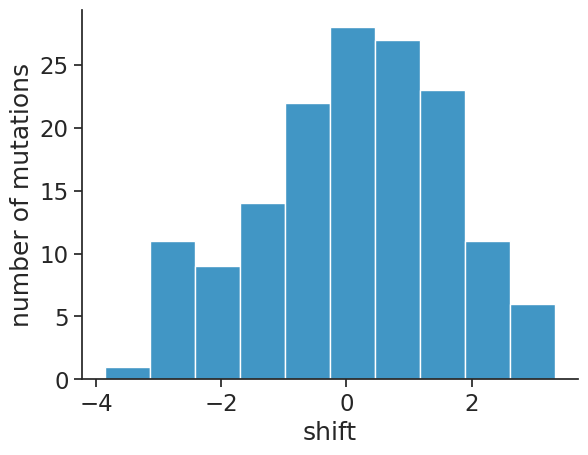

In [13]:
data = mut_effects_df[
    (mut_effects_df['site'].isin(shifted_sites)) &
    ~(mut_effects_df['mutation'].str.contains('\*'))
]
print('Number of mutations with shifts:', len(data))
sns.histplot(data['shift'])
plt.xlabel('shift')
plt.ylabel('number of mutations')
sns.despine()
plt.show()

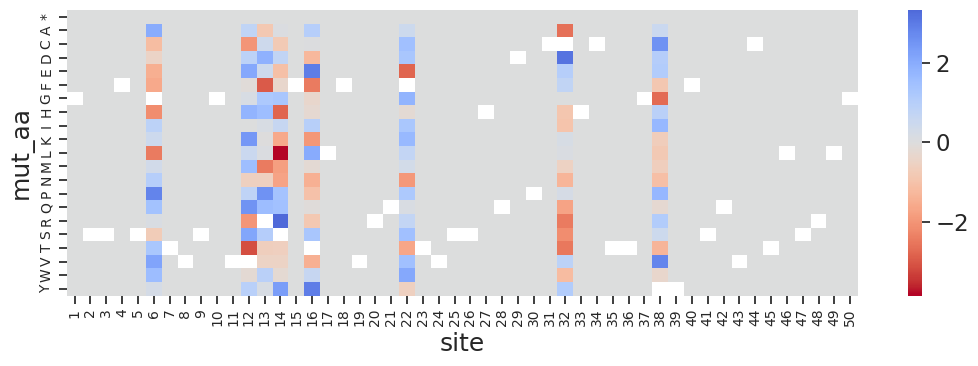

In [14]:

%matplotlib inline

sort_order = sorted([
    "R","K","H","D","E","Q","N","S",
    "T","Y","W","F","A","I","L","M",
    "V","G","P","C","*",
])

fig, ax = plt.subplots(figsize=[11, 4])
sns.heatmap(
    data=mut_effects_df.pivot(index='mut_aa', columns='site', values='shift').loc[sort_order],
    cmap="coolwarm_r",
    center=0,
    ax=ax,
)
ax.set_yticks(
    [s+0.5 for s in range(len(sort_order))],
    labels=sort_order, 
    va="center",
    size=10
)
sites = range(1, 51)
ax.set_xticks(
    [s+0.5 for s in range(len(sites))],
        labels=sites, 
        ha="center",
    rotation=90,
    size=10
)
plt.tight_layout()
plt.show()

Above, we created a `SigmoidPhenotypeSimulator` object for the second homolog by making a copy of the one for the first homolog. This object stores the homolog's wildtype latent phenotype and the latent effects of individual mutations. Below, we update both of these traits based on the simulated shifts from above. To update the wildtype latent phenotype, we will add the effects of all mutations that separate the homologs. In computing this sum, we will use $\beta$ parameters for the second homolog, which already include shifted effects.

In [15]:
# Update individual mutational effects
assert sum(mut_effects_df['mutation'].duplicated()) == 0
for mutation in SigmoidPhenotype_h2.muteffects.keys():
    SigmoidPhenotype_h2.muteffects[mutation] = float(mut_effects_df[mut_effects_df['mutation']==mutation]['beta_h2'])

# Update the wildtype latent phenotype

# grab bundle of mutations separating the two homologs
data = mut_effects_df[
    (mut_effects_df['site'].isin(non_identical_sites)) &
    (mut_effects_df['mut_aa'] == mut_effects_df['aaseq_h2'])
]
# print(data.shape)

wt_latent_phenotype_shift = sum(data['beta_h2'])
SigmoidPhenotype_h2.wt_latent = SigmoidPhenotype_h1.wt_latent + wt_latent_phenotype_shift
print('Characteristics of mutations separating homologs:')
for metric in ['beta_h1', 'shift', 'beta_h2']:
    print(f'Sum of {metric}:', round(sum(data[metric]), 2))
print('Final WT latent phenotype of h2:', round(SigmoidPhenotype_h2.wt_latent, 2))
print('Table of mutations that separate homologs:')
data[[
    'site', 'aaseq_h1', 'aaseq_h2', 'mutation',
    'beta_h1', 'shift', 'beta_h2',
    'shifted_site', 
]]

Characteristics of mutations separating homologs:
Sum of beta_h1: 5.6
Sum of shift: -5.92
Sum of beta_h2: -0.32
Final WT latent phenotype of h2: 4.68
Table of mutations that separate homologs:


site aaseq_h1 aaseq_h2 mutation   beta_h1     shift   beta_h2  \
157     8        V        W      V8W -0.838001  0.000000 -0.838001   
163     9        S        E      S9E -0.956433  0.000000 -0.956433   
266    14        S        H     S14H -0.543773 -2.823528 -3.367301   
633    32        C        R     C32R  1.754504 -2.457132 -0.702628   
682    35        T        D     T35D  0.556320  0.000000  0.556320   
728    37        G        L     G37L -0.000444  0.000000 -0.000444   
750    38        Y        M     Y38M  2.989396 -0.640152  2.349243   
825    42        Q        G     Q42G  1.377466  0.000000  1.377466   
862    44        C        E     C44E  0.095026  0.000000  0.095026   
976    49        L        V     L49V  1.170504  0.000000  1.170504   

     shifted_site  
157         False  
163         False  
266          True  
633          True  
682         False  
728         False  
750          True  
825         False  
862         False  
976         False

All mutations in the second homolog's `SigmoidPhenotypeSimulator` object are defined relative to the wildtype sequence of the first homolog, which we will call the "reference" homolog.
But, to simulate data for the second homolog, we need entries to be relative to the wildtype sequence of the second homolog.
These entries are missing for sites at which the homologs differ in sequence.
For instance, if the wildtype amino acid at site 30 is an A in the first homolog, but is a Y in a second homolog, then the effect of a Y30G is absent from the second homolog's simulator object.

To add these missing entries, we will use a strategy that assumes additivity between mutations at the same site.
For instance, in the above example, a Y30G mutation is defined as the sum of the following two mutations relative to A: A30Y (negated) and A30G.
This approach assumes that mutational effects can be negated, such that A30Y has the opposite effect as Y30A.
It also assumes that mutational effects are additive, such that the effect of Y30G is the sum of the effects of Y30A and A30G.

The below expression defines this approach more explicitly for an arbitrary site.
It uses the notation $\beta_{x,n,z}$ where $x$ and $z$ are amino acids.
For a site $n$, if $aa_{\text{wt}}$ is the site's wildtype amino acid in a non-reference homolog, $aa_{\text{mut}}$ is a mutant amino acid in a variant of that homolog, and $aa_{\text{ref}}$ is the site's wildtype amino acid in the reference homolog, then the mutation's effect is:

$$\beta_{aa_{\text{wt}},n,aa_{\text{mut}}} = \begin{cases}
      \beta_{aa_{\text{ref}},n,aa_{\text{mut}}} & \text{if } aa_{\text{wt}} = aa_{\text{ref}}\\
      -\beta_{aa_{\text{ref}},n,aa_{\text{wt}}} & \text{if } aa_{\text{mut}} = aa_{\text{ref}}\\
      - \beta_{aa_{\text{ref}},n,aa_{\text{wt}}} +\beta_{aa_{\text{ref}},n,aa_{\text{mut}}} & \text{otherwise}\\
\end{cases}$$

The above $\beta$ parameters are effects in the background of the non-reference homolog, such that they account for shifts in mutational effects between homologs.

The below cell adds mutational effects for missing entries using the above strategy.

In [16]:
# Iterate over non-identical sites
# -15 might not accuarately reflect just how deleterious these should be compared to an laten wildtype
# phenotype of 5 (which is seemingly the default).
for site in non_identical_sites:
    
    aa_h1 = aaseq_h1[site-1]
    aa_h2 = aaseq_h2[site-1]
    assert (aa_h1 != aa_h2), site
    
    # Get the effect of the mutation that goes between homologs
    mut_between_homologs = f'{aa_h1}{site}{aa_h2}'
    mut_between_homologs_effect = float(mut_effects_df[
        mut_effects_df['mutation'] == mut_between_homologs
    ]['beta_h2'])
    
    # Iterate over mutant amino acids and add an entry for
    # each one
    for aa_mut in AAS_WITHSTOP:
        if aa_h2 == aa_mut:
            continue
        elif aa_mut == '*':
            SigmoidPhenotype_h2.muteffects[f'{aa_h2}{site}{aa_mut}'] = stop_effect
        elif aa_mut == aa_h1:
            SigmoidPhenotype_h2.muteffects[f'{aa_h2}{site}{aa_mut}'] = -mut_between_homologs_effect
        else:            
            # Get the effect of the mutation that goes from the
            # reference amino acid to the original mutant amino acid
            mut_from_ref = f'{aa_h1}{site}{aa_mut}'
            mut_from_ref_effect = float(mut_effects_df[
                mut_effects_df['mutation'] == mut_from_ref
            ]['beta_h2'])
            SigmoidPhenotype_h2.muteffects[f'{aa_h2}{site}{aa_mut}'] = -mut_between_homologs_effect + mut_from_ref_effect

mut_effects_df.head()

mutation   beta_h1 wt_aa  site mut_aa  shifted_site  shift   beta_h2  \
0      G1A -5.811474     G     1      A         False    0.0 -5.811474   
1      G1C -8.878036     G     1      C         False    0.0 -8.878036   
2      G1D -1.013877     G     1      D         False    0.0 -1.013877   
3      G1E -8.349956     G     1      E         False    0.0 -8.349956   
4      G1F -1.349155     G     1      F         False    0.0 -1.349155   

  aaseq_h1 aaseq_h2  
0        G        G  
1        G        G  
2        G        G  
3        G        G  
4        G        G

## Simulate variant libraries and selection

### Variant libraries with phenotypes and enrichments


Simulate a set of variant libraries that one might use in an actual experiment for each homolog, each with two replicate libraries.

In [17]:
CodonVariantTable_h1 = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq_h1,
    bclen=bclen,
    library_specs={
        lib: {"avgmuts": avgmuts, "nvariants": variants_per_lib} for lib in libs
    },
    seed=seed,
)
CodonVariantTable_h2 = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq_h2,
    bclen=bclen,
    library_specs={
        lib: {"avgmuts": avgmuts, "nvariants": variants_per_lib} for lib in libs
    },
    seed=seed,
)

In [18]:
CodonVariantTable_h1.n_variants_df(samples=None)

library             sample  count
0          lib_1  barcoded variants  25000
1          lib_2  barcoded variants  25000
2  all libraries  barcoded variants  50000

In [19]:
len(CodonVariantTable_h2.barcode_variant_df.barcode.unique())

50000

plot the number of variant support sequences as a histogram

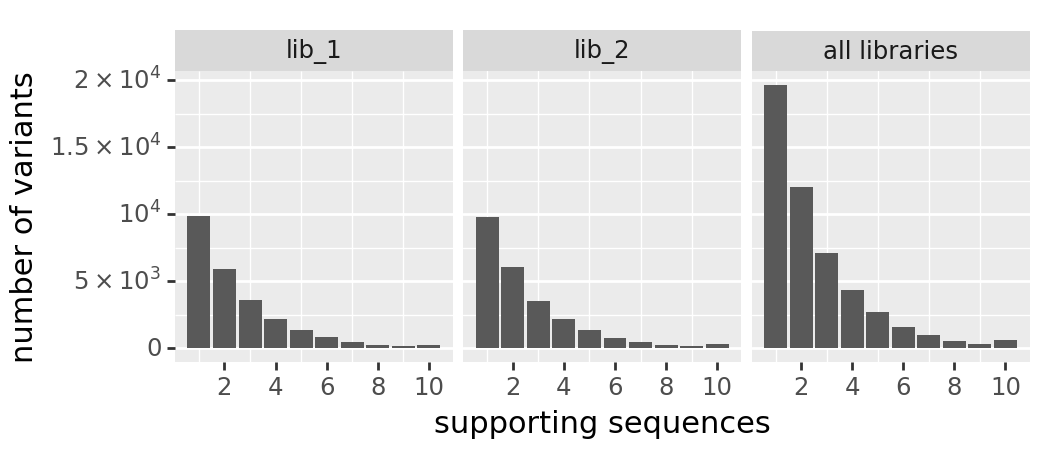

In [20]:
p = CodonVariantTable_h1.plotVariantSupportHistogram(max_support=10)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

In [21]:
CodonVariantTable_h2.n_variants_df(samples=None)

library             sample  count
0          lib_1  barcoded variants  25000
1          lib_2  barcoded variants  25000
2  all libraries  barcoded variants  50000

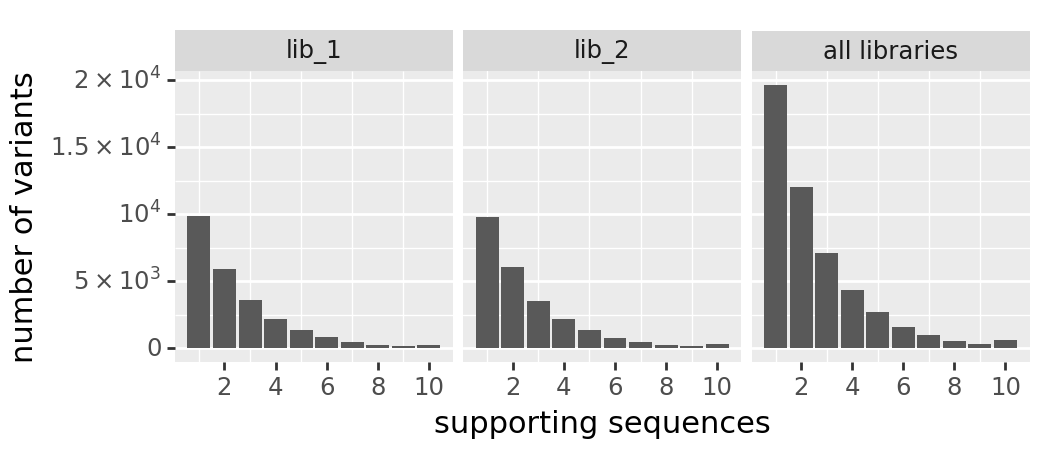

In [22]:
p = CodonVariantTable_h2.plotVariantSupportHistogram(max_support=10)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)


For each homolog, simulate latent and observed phenotypes for each variant given the underlying mutation effects from above.

In [23]:
# First homolog
phenotypes_h1 = [
    (SigmoidPhenotype_h1.latentPhenotype, 'latent_phenotype'),
    (SigmoidPhenotype_h1.observedPhenotype, 'observed_phenotype'),
    (SigmoidPhenotype_h1.observedEnrichment, 'observed_enrichment'),
]
for (func, col_name) in phenotypes_h1:
    CodonVariantTable_h1.barcode_variant_df[col_name] = \
        CodonVariantTable_h1.barcode_variant_df['aa_substitutions'].apply(lambda x: func(x))
    
# Second homolog
phenotypes_h2 = [
    (SigmoidPhenotype_h2.latentPhenotype, 'latent_phenotype'),
    (SigmoidPhenotype_h2.observedPhenotype, 'observed_phenotype'),
    (SigmoidPhenotype_h2.observedEnrichment, 'observed_enrichment'),
]
for (func, col_name) in phenotypes_h2:
    CodonVariantTable_h2.barcode_variant_df[col_name] = \
        CodonVariantTable_h2.barcode_variant_df['aa_substitutions'].apply(lambda x: func(x))

The above computation uses a sigmoid to convert a latent phenotype to an observed one. Below, we plot these sigmoids for each of the homologs:

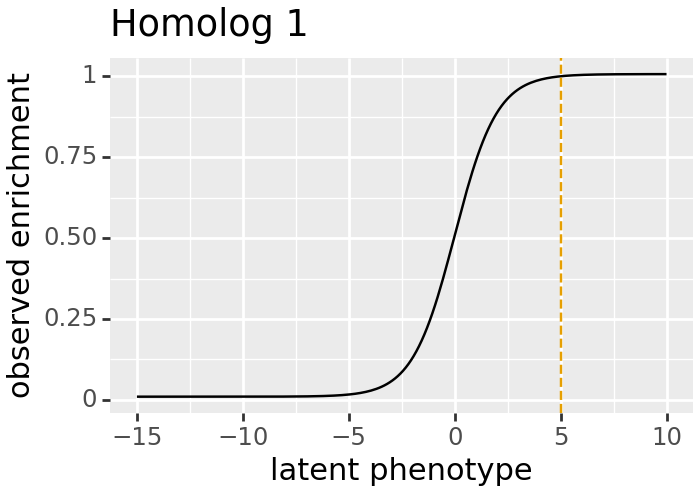

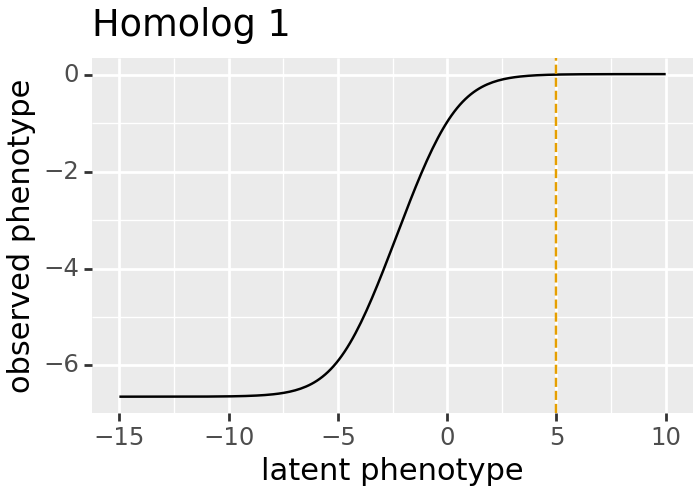

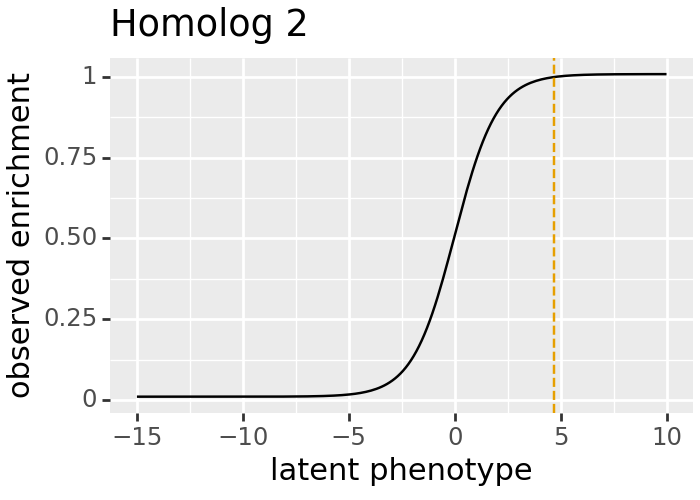

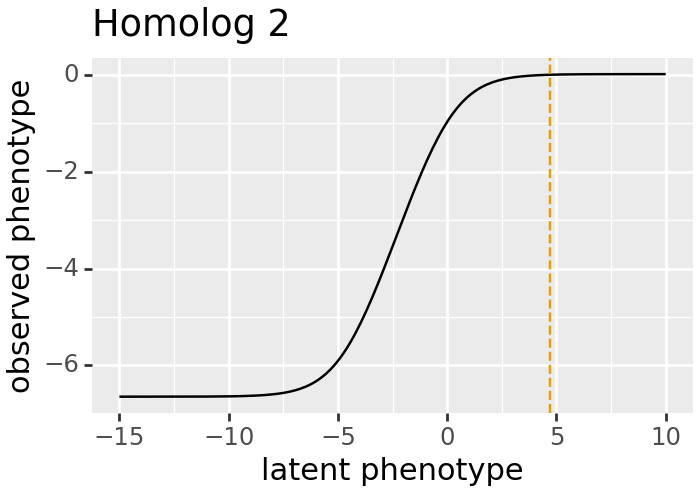

In [24]:
for homolog, phenosimulator in zip([1, 2], [SigmoidPhenotype_h1, SigmoidPhenotype_h2]):
    for value in ["enrichment", "phenotype"]:
        p = phenosimulator.plotLatentVsObserved(value)
        p += labs(title = f'Homolog {homolog}')
        p.draw(show=True)

### Pre and post-selection variant read counts

Next, we would like to simulate both pre and post-selection counts of each variant in each experiment in proportion to their ground-truth `"observed_enrichment"`. Post selection counts will be simulated by applying the specified selection bottleneck(s), to the pre-selection counts. To do this, we will use the `simulate_counts` function from `dms_variants.simulate` and the `compute_scores` function from `dms_variants.codonvarianttable`.

In [25]:
# do this independently for each of the homologs.
counts_h1, counts_h2 = [
    dms_variants.simulate.simulateSampleCounts(
        variants=variants,
        phenotype_func=phenosimulator.observedEnrichment,
        variant_error_rate=variant_error_rate,
        pre_sample={
            "total_count": variants_per_lib * np.random.poisson(avgdepth_per_variant),
            "uniformity": lib_uniformity,
        },
        pre_sample_name="pre-selection",
        post_samples={
            name: {
                "noise": noise,
                "total_count": variants_per_lib * np.random.poisson(avgdepth_per_variant),
                "bottleneck": bottleneck,
            }
            for name, bottleneck in bottlenecks.items()
        },
        seed=seed,
    )
    for variants, phenosimulator in zip(
        [CodonVariantTable_h1, CodonVariantTable_h2], [SigmoidPhenotype_h1, SigmoidPhenotype_h2]
    )
]
CodonVariantTable_h1.add_sample_counts_df(counts_h1)
CodonVariantTable_h2.add_sample_counts_df(counts_h2)

Plot the number of counts for each variant in each sample. The horizontal dashed line shows the total number of variants. The plot shows that all variants are well-sampled in the pre-selection libraries, but that post- selection some variants are sampled more or less. This is expected since selection will decrease and increase the frequency of variants:

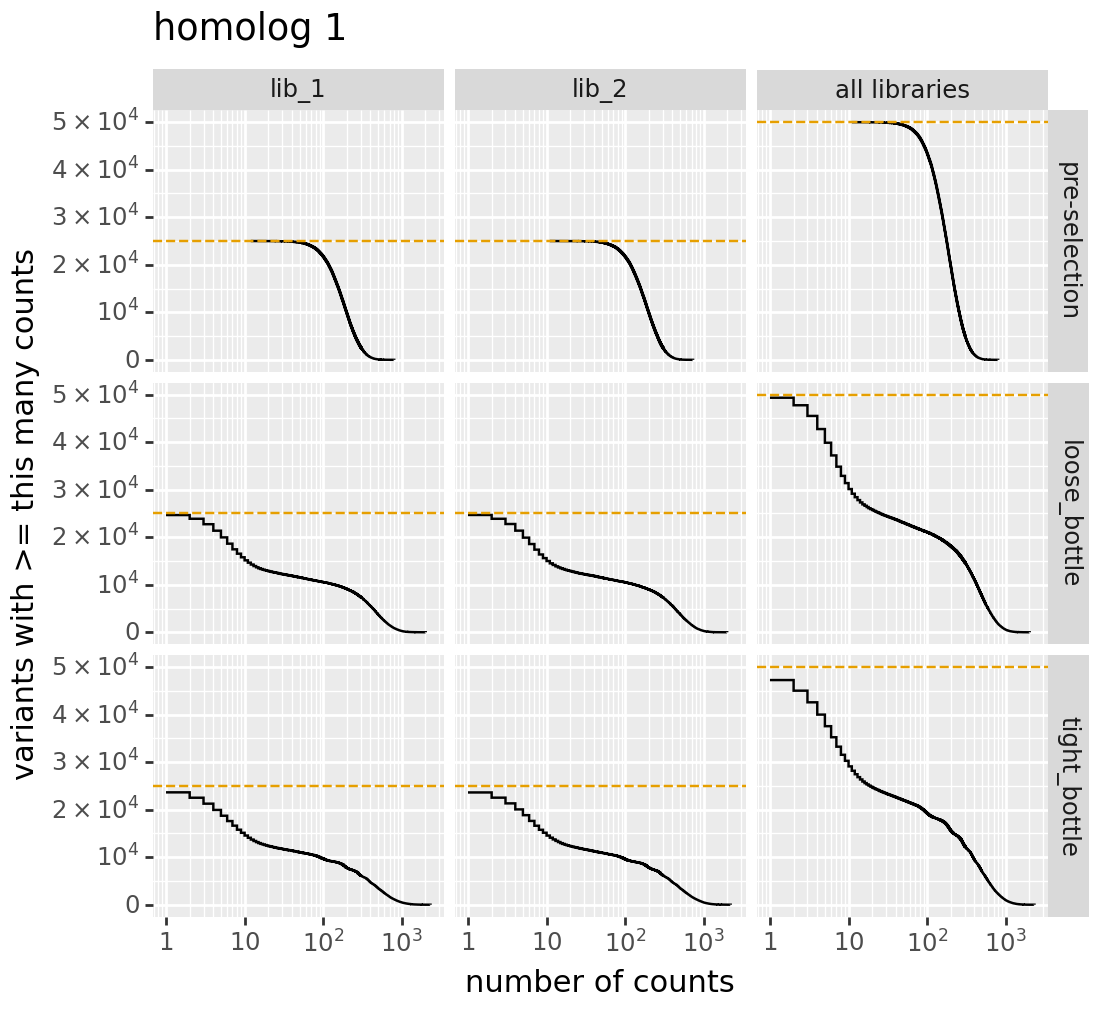

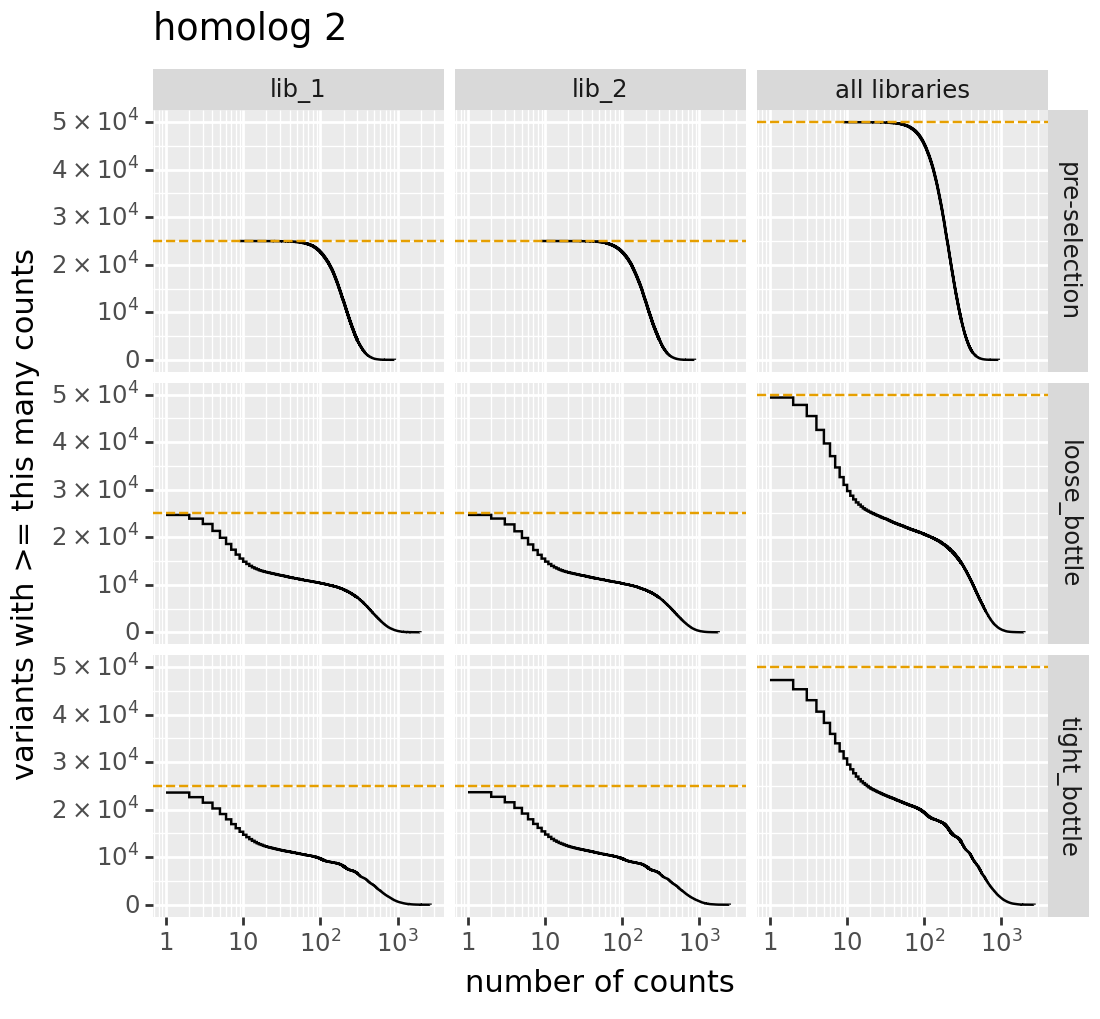

In [26]:
for variants, title in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['homolog 1', 'homolog 2']):
    p = variants.plotCumulVariantCounts()
    p += labs(title=title)
    _ = p.draw(show=True)

Distribution of the number of amino-acid mutations per variant in each sample. As expected, mutations go down after selection:

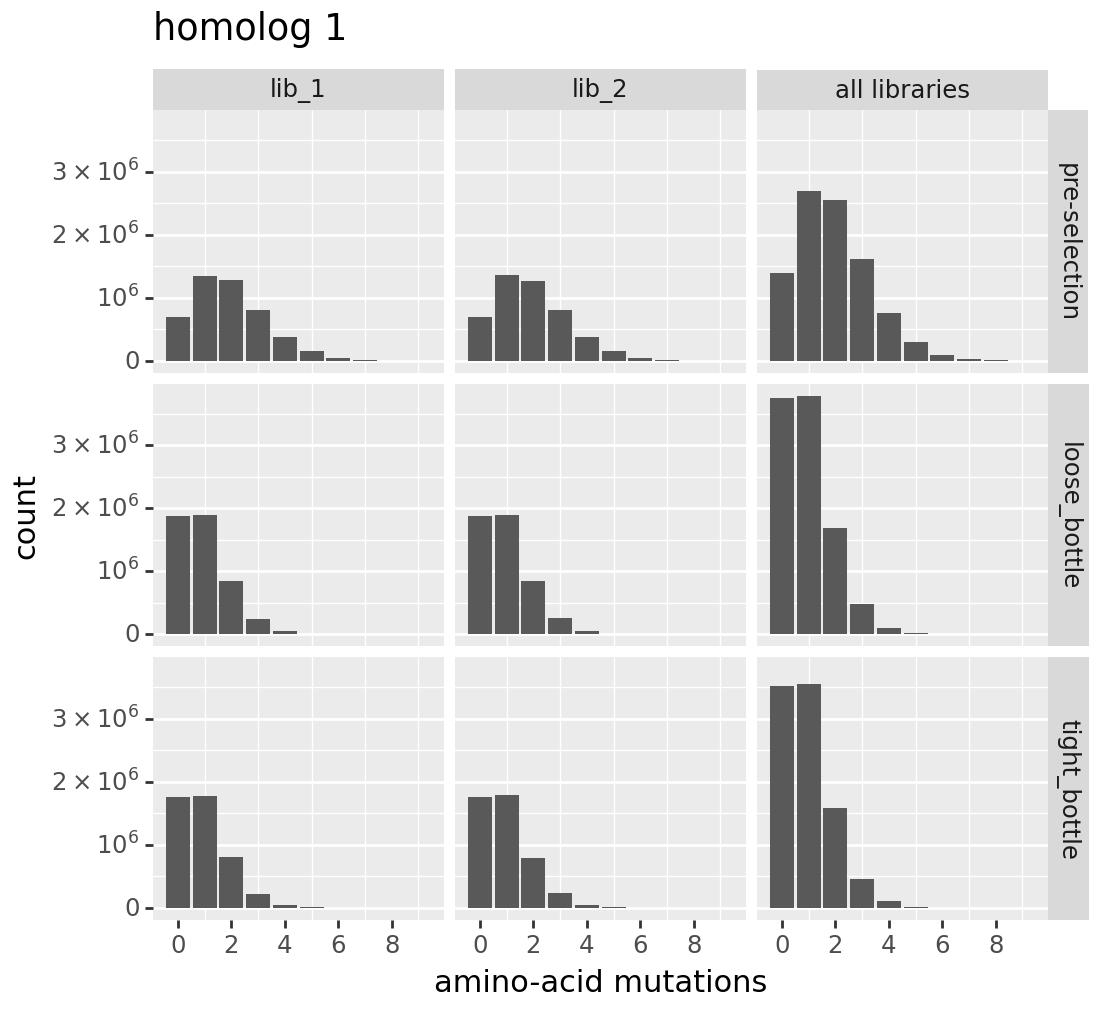

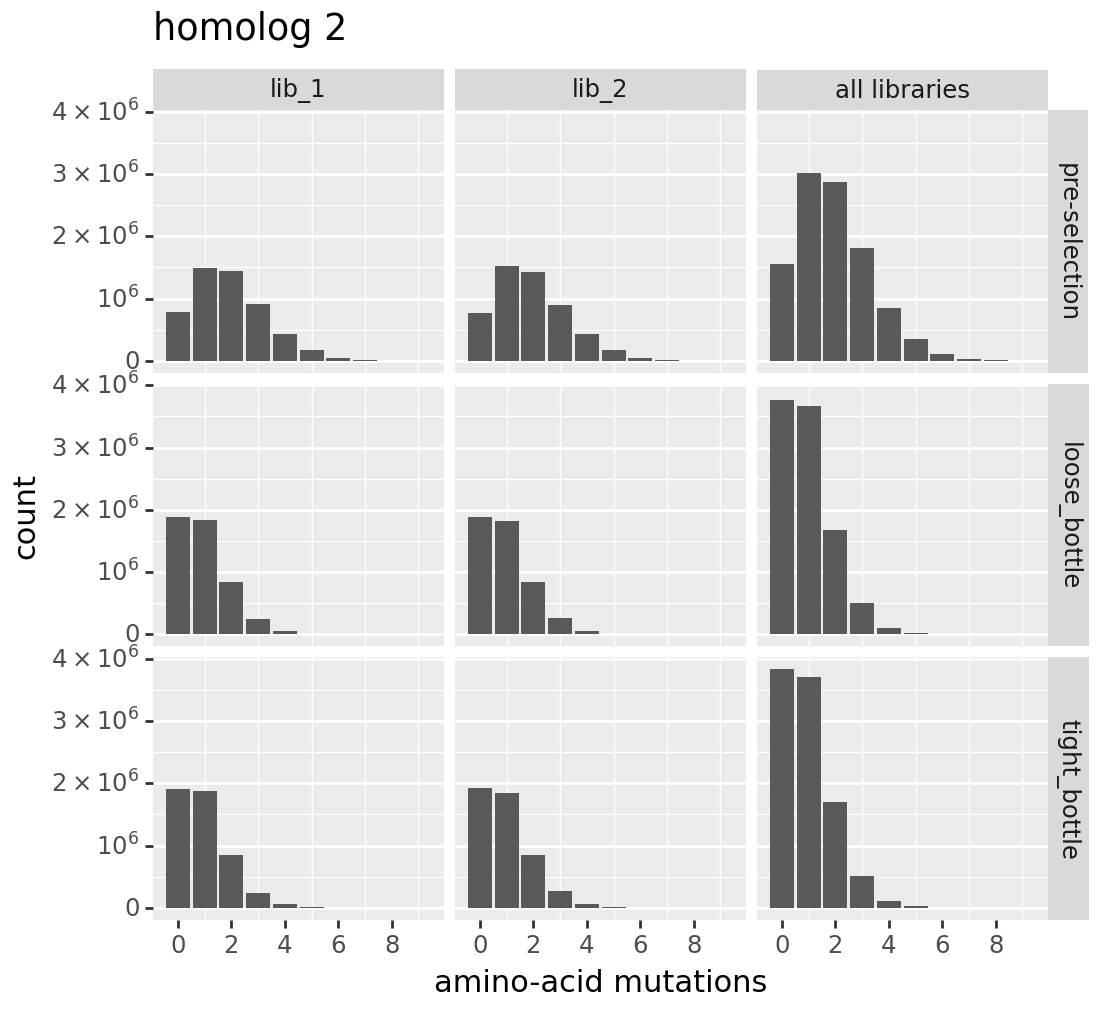

In [27]:
for variants, title in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['homolog 1', 'homolog 2']):
    p = variants.plotNumMutsHistogram(mut_type="aa")
    p += theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    p += labs(title=title)
    _ = p.draw(show=True)

Plot how thoroughly amino-acid mutations are sampled, doing this separately among all variants and single-mutant variants. The plots below show that the stop mutations are sampled very poorly post-selection because they are eliminated during selection:

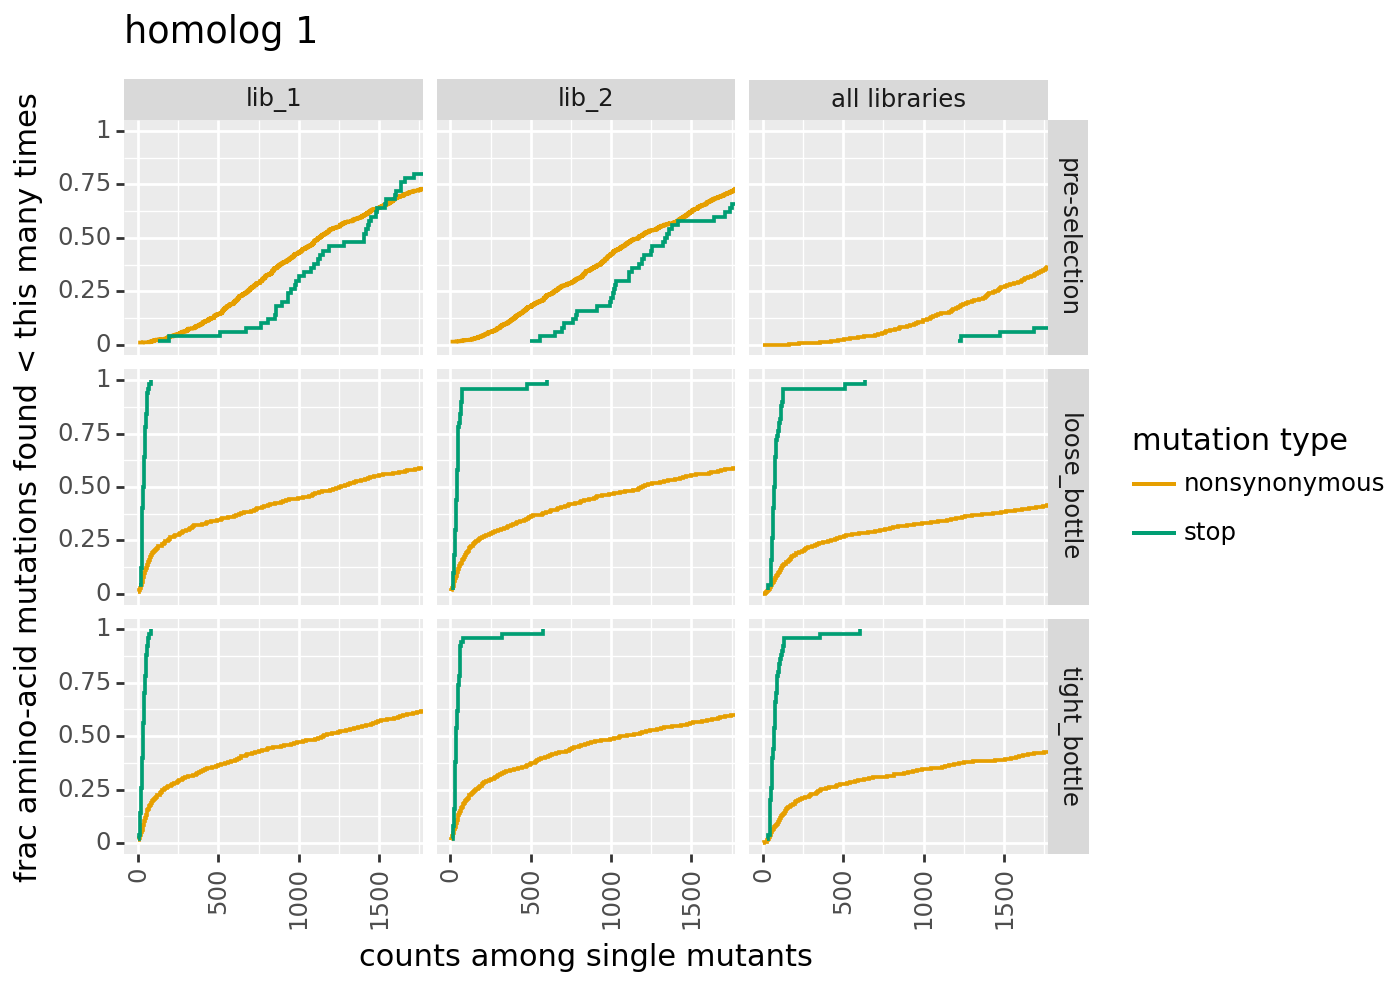

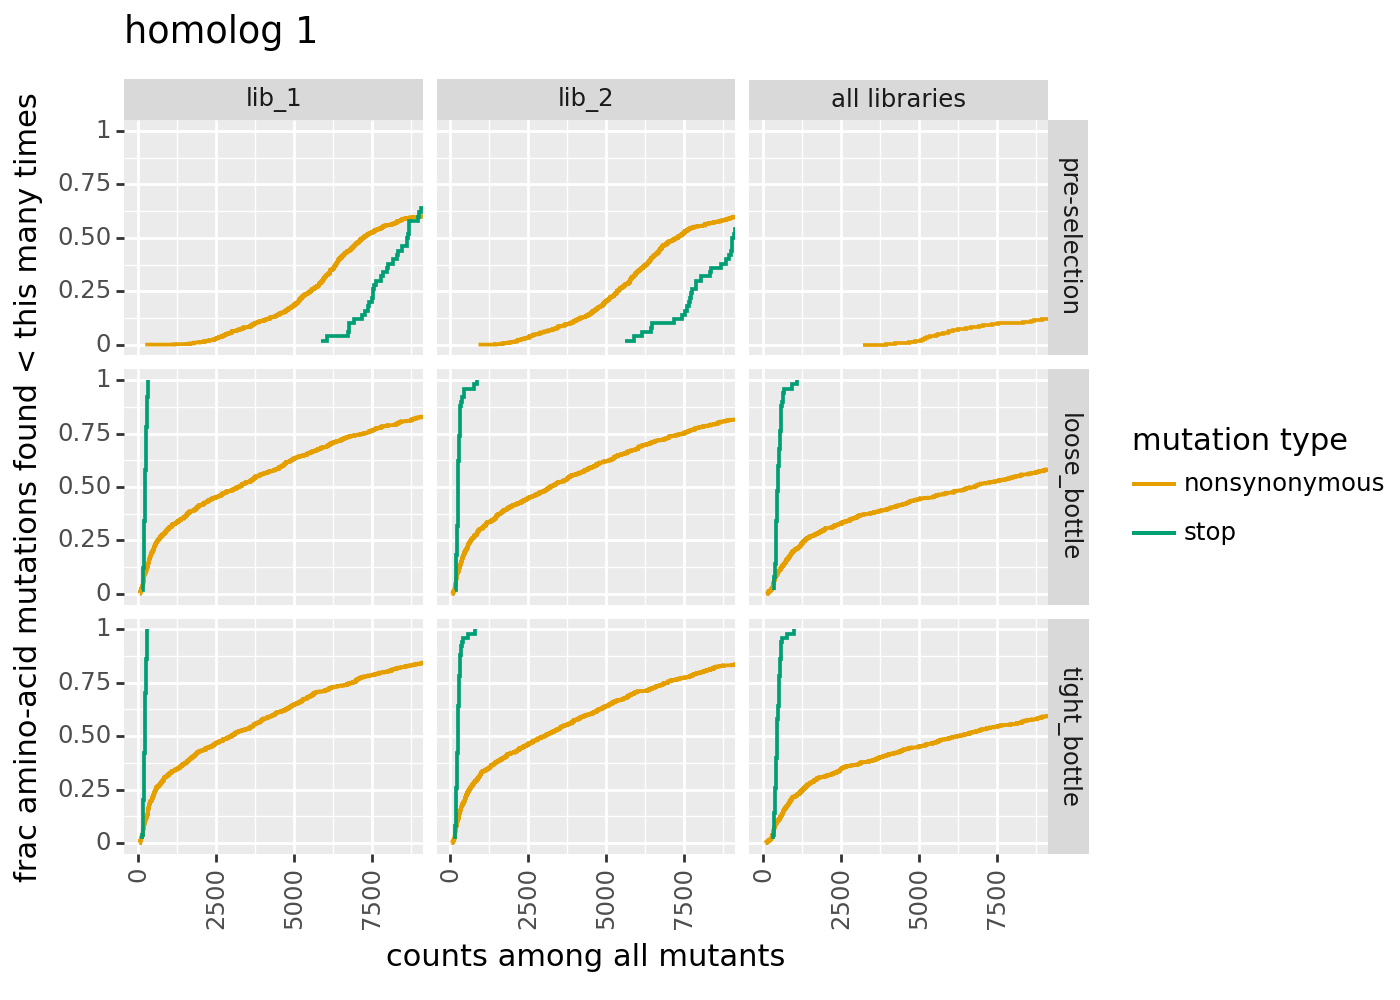

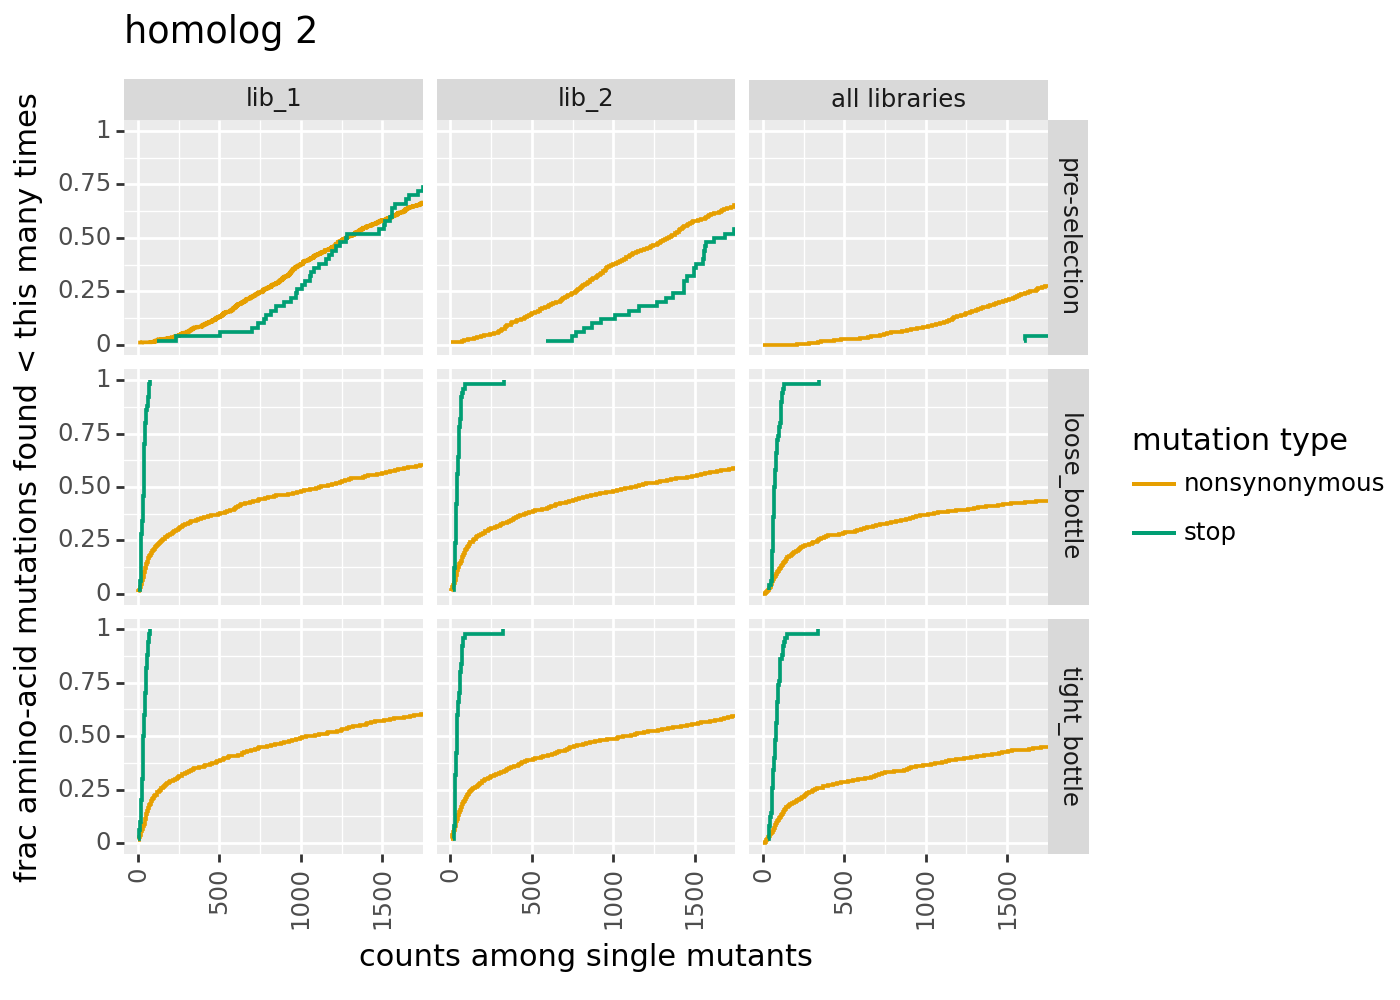

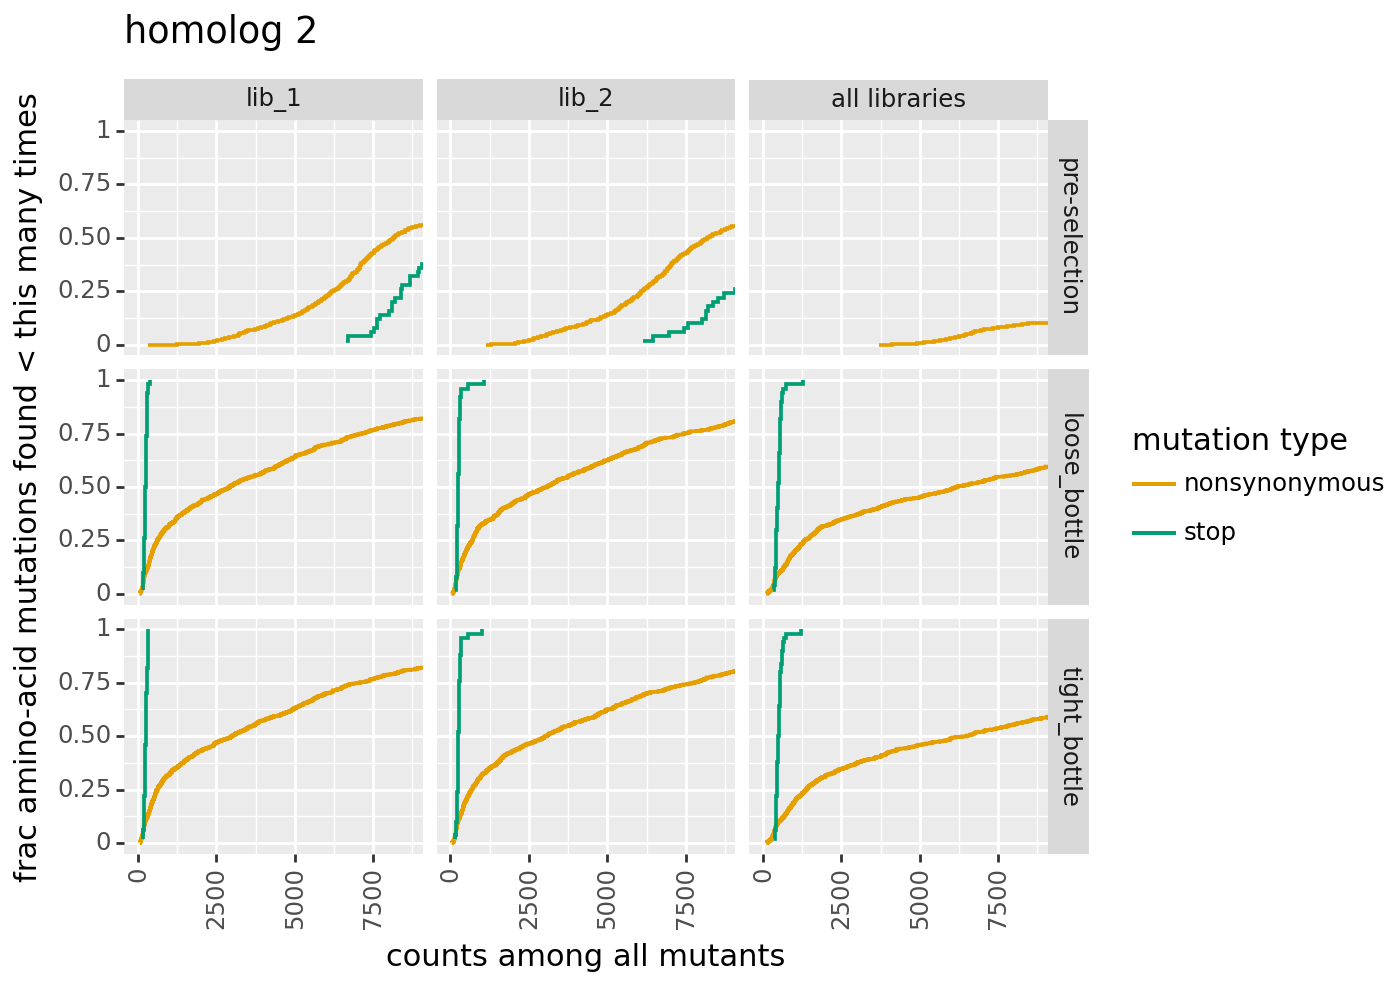

In [28]:
for variants, title in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['homolog 1', 'homolog 2']):
    for variant_type in ["single", "all"]:
        p = variants.plotCumulMutCoverage(variant_type=variant_type, mut_type="aa")
        p += labs(title=title)
        p += theme(figure_size=(7, 5))
        _ = p.draw(show=True)

## `multidms` Modeling

### Prep training data


Prepare the training dataframes for fitting our joint `multidms` models. Each dataset requires a dataframe with the following columns:

- `condition`: the experimental condition of the sample, in this case, the homolog.
- `aa_substitutions`: the variant as defined by it's mutations mutations to the homolog wildtype
- `func_score`: the functional score of the variant

For the purposes of this analysis, we'll create a training dataset for each functional score type (ground truth "observed_phenotype", plus the defined bottleneck-counts derived functional scores), for each library replicate (combining the respective homolog library replicates). e.g. if you have defined 2 bottlenecks, and two library replicates, you can expect 2 bottlenecks * 2 library replicates + 2 ground truth datasets = 6 training datasets total.




Start by creating training data with ground truth phenotype target. Because the barcode replicates share ground truth phenotypes we can can collapse the counts accross replicates by simple dropping duplicates. define the required columns and their order

In [29]:
req_cols = ["library", "condition", "aa_substitutions", "func_score_type", "func_score"]
ground_truth_training_set = (
    pd.concat(
        [
            variants.barcode_variant_df[["library", "aa_substitutions", "observed_enrichment", "observed_phenotype"]]
            .drop_duplicates()
            .assign(condition=homolog)
            for variants, homolog in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['h1', 'h2'])
        ]
    )
    .melt(
        id_vars=["library", "aa_substitutions", "condition"],
        value_vars=["observed_enrichment", "observed_phenotype"],
        var_name="func_score_type",
        value_name="func_score",
    )
    [req_cols]
    .astype({c:str for c in req_cols[:-1]})
)
ground_truth_training_set.head()


library condition                         aa_substitutions  \
0   lib_1        h1  V24Q S25R H27P D29L H33C S41L C44F S47F   
1   lib_1        h1                       V8P H27T P30* L49P   
2   lib_1        h1                                V19P V43Q   
3   lib_1        h1                                     R20Y   
4   lib_1        h1                                            

       func_score_type  func_score  
0  observed_enrichment    0.010000  
1  observed_enrichment    0.010000  
2  observed_enrichment    0.010142  
3  observed_enrichment    0.952440  
4  observed_enrichment    1.000000

Next, compute functional scores from pre-post counts in each bottleneck _after_ aggregating the barcode replicate counts for unique variants.

In [31]:
# Collapsing counts accross replicate `aa_substituitions` _before_ computing the functional score.
bottle_cbf = pd.concat(
    [
        (
            variants
            .func_scores("pre-selection", by="aa_substitutions", libraries=libs, syn_as_wt=True)
            .assign(condition=homolog)
            .rename({"post_sample":"func_score_type"}, axis=1)
            [req_cols]
            .astype({c:str for c in req_cols[:-1]})
        )
        for variants, homolog in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['h1', 'h2'])
    ]
)
bottle_cbf.head()

library condition aa_substitutions func_score_type  func_score
0   lib_1        h1             Q28P    loose_bottle   -0.258227
1   lib_1        h1             G50E    loose_bottle    0.075144
2   lib_1        h1             R48G    loose_bottle   -2.659408
3   lib_1        h1    S3R G10Y L49H    loose_bottle   -6.577912
4   lib_1        h1   F18T Q21E C44T    loose_bottle   -6.193633

Finally, combine the two dataframes computed above, and classify the variants based on the number of amino acid substitutions.

In [32]:

def classify_variant(aa_subs):
    if "*" in aa_subs:
        return "stop"
    elif aa_subs == "":
        return "wildtype"
    elif len(aa_subs.split()) == 1:
        return "1 nonsynonymous"
    elif len(aa_subs.split()) > 1:
        return ">1 nonsynonymous"
    else:
        raise ValueError(f"unexpected aa_subs: {aa_subs}")

func_scores = (
    pd.concat([ground_truth_training_set, bottle_cbf])
    .assign(variant_class = lambda x: x['aa_substitutions'].apply(classify_variant))
)

print(func_scores.groupby(["library", "func_score_type"]).size(), "\n")
func_scores.head()

library  func_score_type    
lib_1    loose_bottle           30244
         observed_enrichment    30244
         observed_phenotype     30244
         tight_bottle           30244
lib_2    loose_bottle           30208
         observed_enrichment    30208
         observed_phenotype     30208
         tight_bottle           30208
dtype: int64 



library condition                         aa_substitutions  \
0   lib_1        h1  V24Q S25R H27P D29L H33C S41L C44F S47F   
1   lib_1        h1                       V8P H27T P30* L49P   
2   lib_1        h1                                V19P V43Q   
3   lib_1        h1                                     R20Y   
4   lib_1        h1                                            

       func_score_type  func_score     variant_class  
0  observed_enrichment    0.010000  >1 nonsynonymous  
1  observed_enrichment    0.010000              stop  
2  observed_enrichment    0.010142  >1 nonsynonymous  
3  observed_enrichment    0.952440   1 nonsynonymous  
4  observed_enrichment    1.000000          wildtype

Plot a pairplot to see how targets compare.

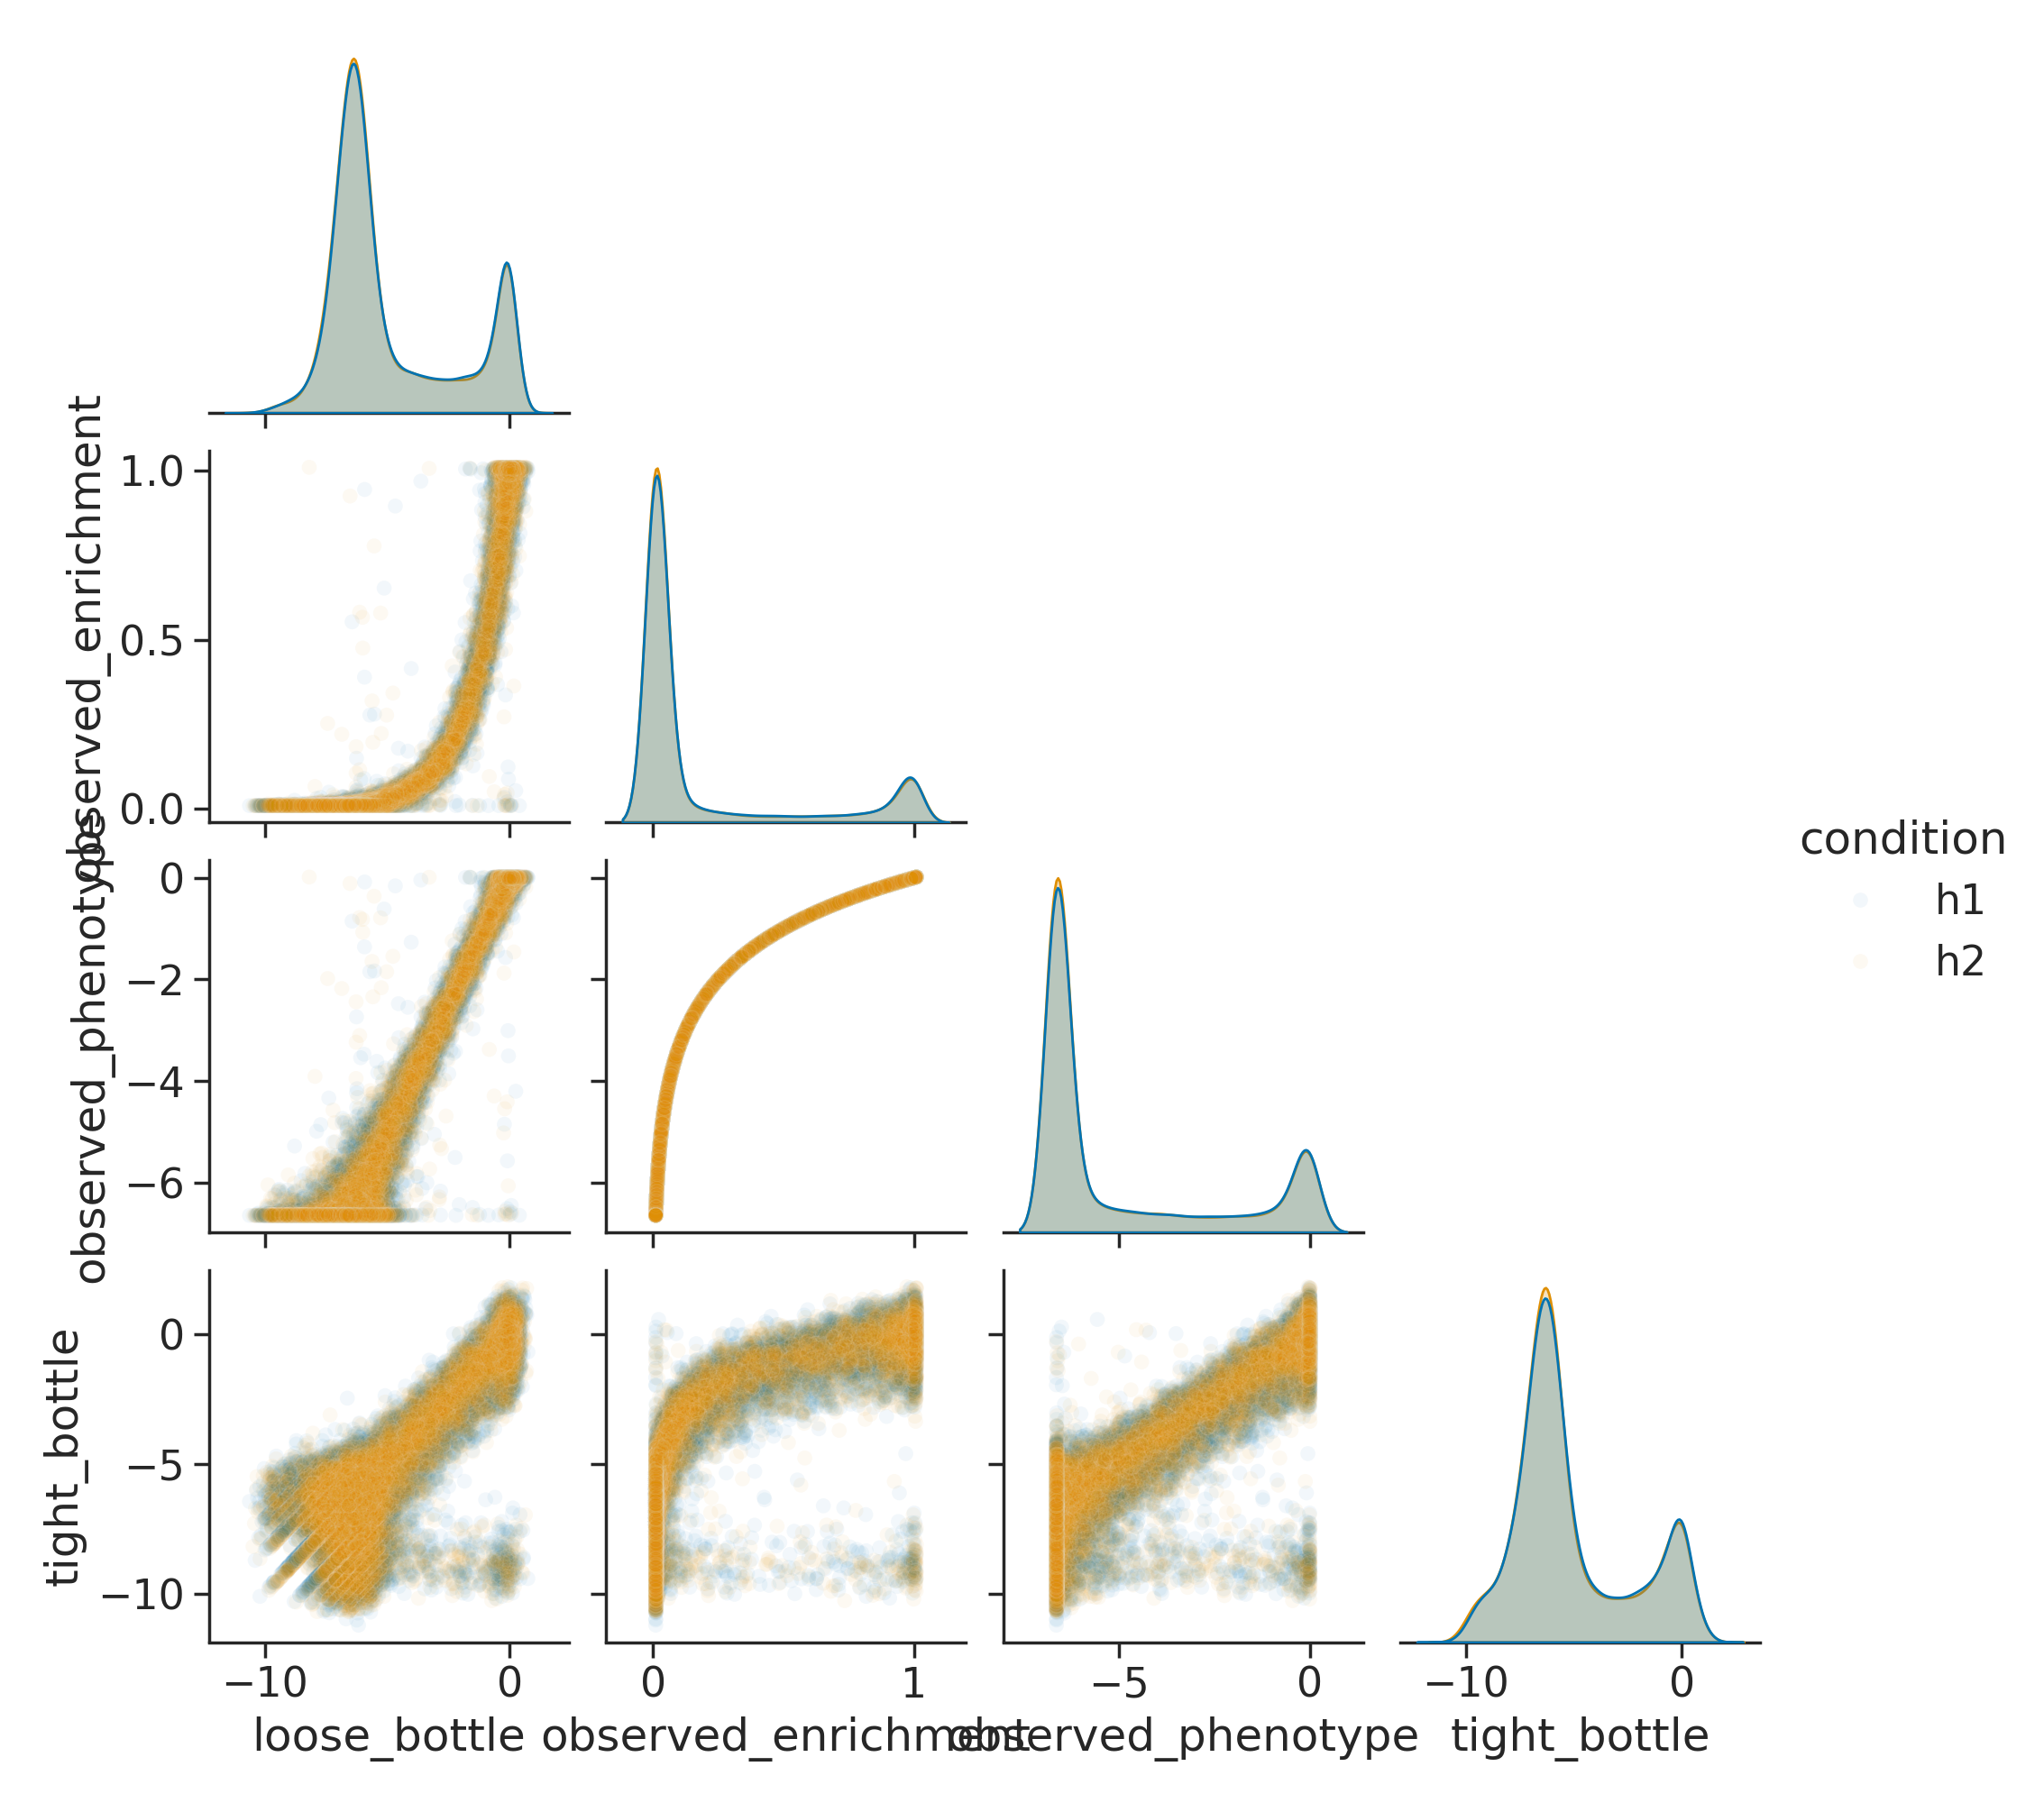

In [33]:
sns.pairplot(
    (
        func_scores
        .pivot(
            index=["library", "condition", "aa_substitutions", "variant_class"],
            columns="func_score_type",
            values="func_score"
        )
        .reset_index()
    ),  
    hue='condition',
    plot_kws = {"alpha":0.05},
    corner=True
)

Plot the functional scores distributions of the bottleneck counts-computed functional scores.

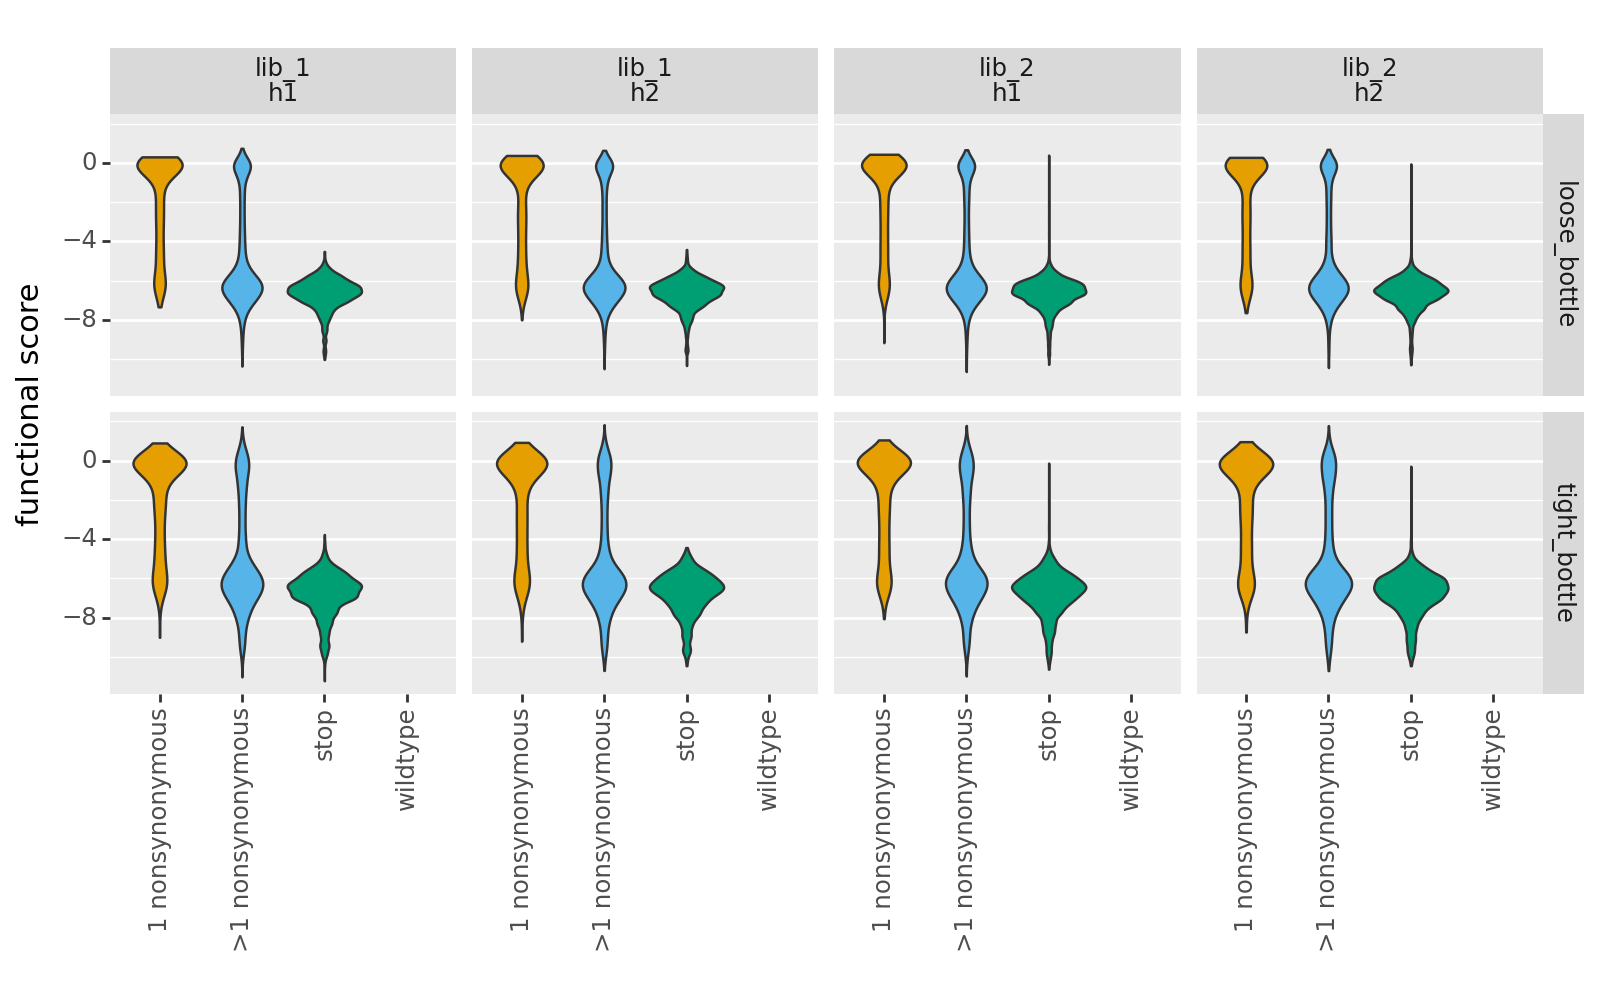

In [34]:
# for func_scores, title in zip([func_scores_h1, func_scores_h2], ['homolog 1', 'homolog 2']):
# for title, df in func_scores.group
p = (
    ggplot(
        func_scores.query("(func_score_type != 'observed_phenotype') & (func_score_type != 'observed_enrichment')"), 
        aes("variant_class", "func_score")
    )
    + geom_violin(aes(fill="variant_class"))
    + ylab("functional score")
    + xlab("")
    + facet_grid("func_score_type ~ library + condition")
    + theme(
        # figure_size=(3.75 * len(libs), 1.4 * len(func_scores["func_score_type"].unique())),
        figure_size=(8, 5),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + scale_fill_manual(values=CBPALETTE[1:], guide=False)
    # + labs(title=title)
)
_ = p.draw(show=True)

### Create `Data` objects for each library replicate, and bottleneck

`multidms` model fitting is generally a two-step process: (1) Create `Data` objects from functional score dataframes, which, among other things, encode the variant data into one-hot encoded matrices, and (2) fit a collection of models across a grid of `Data` objects and hyperparameters. Here, we'll create `Data` objects for each library replicate, and bottleneck:

In [35]:
data_objects = [
    multidms.Data(
        fs_df, 
        reference="h1", 
        alphabet = multidms.AAS_WITHSTOP_WITHGAP, 
        verbose=False,
        name = f"{lib}_{target}_func_score"
    )
    for (lib, target), fs_df in func_scores.groupby(['library', 'func_score_type'])
    if "enrichment" not in target
]

data_objects

[Data(lib_1_loose_bottle_func_score),
 Data(lib_1_observed_phenotype_func_score),
 Data(lib_1_tight_bottle_func_score),
 Data(lib_2_loose_bottle_func_score),
 Data(lib_2_observed_phenotype_func_score),
 Data(lib_2_tight_bottle_func_score)]

### Fit models to training data

Next, we'll fit a set of models to each of the datasets defined above using `multidms.fit_models`. For each dataset, we independently fit models with a number of different lasso penalty coefficients, $\lambda$, as defined at the top of this notebook. 

In [44]:
fitting_params["dataset"] = data_objects
pprint.pprint(fitting_params)

{'dataset': [Data(lib_1_loose_bottle_func_score),
             Data(lib_1_observed_phenotype_func_score),
             Data(lib_1_tight_bottle_func_score),
             Data(lib_2_loose_bottle_func_score),
             Data(lib_2_observed_phenotype_func_score),
             Data(lib_2_tight_bottle_func_score)],
 'init_beta_naught': [5.0],
 'iterations_per_step': [100],
 'scale_coeff_lasso_shift': [0.0, 1e-05, 2e-05, 5e-05, 0.0001, 0.0002, 0.0003]}


`multidms.fit_models` takes a dictionary, keyed by specified hyperparameters, as input. Each value is a list, and the resulting collection of model fits is the cartesian product of these lists. If a given hyper parameter is not specified, the default is used, see the docstring for `multidms.fit_models` for more details.


In [45]:
_, _, fit_collection = multidms.model_collection.fit_models(fitting_params)

In [208]:
# ENTRY POINT
import pickle
fit_collection = pickle.load(open("fit_collectio.pkl", "rb"))


Note that the return type of `multidms.fit_models` is a tuple (int, int, pd.DataFrame) where the first two values are the number of fits that were successful and the number that failed, respectively, and the third value is a dataframe where each row contains a fit `Model` object and the hyperparameters used to fit it.

In [209]:
fit_collection[["model", "dataset_name", "scale_coeff_lasso_shift"]].head()

model                   dataset_name scale_coeff_lasso_shift
0  Model(Model-0)  lib_1_loose_bottle_func_score                     0.0
1  Model(Model-1)  lib_1_loose_bottle_func_score                 0.00001
2  Model(Model-2)  lib_1_loose_bottle_func_score                 0.00002
3  Model(Model-0)  lib_1_loose_bottle_func_score                 0.00005
4  Model(Model-1)  lib_1_loose_bottle_func_score                  0.0001

Add a few helpful features to this dataframe for plotting by splitting the "dataset_name" (name of the Data Object that was used for fitting) into more understandable columns:

In [210]:
# The datasets were named <training_target>_<library_replicate> - let's parse those
fit_collection["measurement_type"] = fit_collection["dataset_name"].str.split("_").str[2:4].str.join("_")
fit_collection["library"] = fit_collection["dataset_name"].str.split("_").str[0:2].str.join("_")

# convert measurement type to categorical ordered by 'observed', 'loose', 'tight'
fit_collection["measurement_type"] = pd.Categorical(
    fit_collection["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)

fit_collection[["model", "measurement_type", "library", "scale_coeff_lasso_shift"]].head()

model measurement_type library scale_coeff_lasso_shift
0  Model(Model-0)     loose_bottle   lib_1                     0.0
1  Model(Model-1)     loose_bottle   lib_1                 0.00001
2  Model(Model-2)     loose_bottle   lib_1                 0.00002
3  Model(Model-0)     loose_bottle   lib_1                 0.00005
4  Model(Model-1)     loose_bottle   lib_1                  0.0001

### Predicted vs. Simulated Ground Truth

First, let's grab the model predictions of latent, and observed phenotypes for each of the datasets using `multidms.Model.get_variants_df`. 

In [211]:
variants_df = pd.concat(
    [
        row.model.get_variants_df(phenotype_as_effect=True)
        .assign(
            library=row.library,
            measurement_type=row.measurement_type,
            scale_coeff_lasso_shift=row.scale_coeff_lasso_shift,
        )
        .rename(
            {
                "predicted_func_score": "predicted_phenotype", # wt is zero-centered (as_effect=True)
                "predicted_latent": "predicted_latent_phenotype",
                "func_score" : "measured_phenotype",
            },
            axis=1,
        )
        # add enrichments
        .assign(
            predicted_enrichment = lambda x: 2**x['predicted_phenotype'],
            measured_enrichment = lambda x: 2**x['measured_phenotype'],
            fit_idx = idx
        )
        for idx, row in fit_collection.iterrows()
    ]
)
variants_df.head()

condition aa_substitutions  measured_phenotype     var_wrt_ref  \
0        h1             Q28P           -0.258227            Q28P   
1        h1             G50E            0.075144            G50E   
2        h1             R48G           -2.659408            R48G   
3        h1    S3R G10Y L49H           -6.577912   S3R G10Y L49H   
4        h1   F18T Q21E C44T           -6.193633  F18T Q21E C44T   

   predicted_latent_phenotype  predicted_phenotype library measurement_type  \
0                   -2.557173            -0.267090   lib_1     loose_bottle   
1                   -1.216951            -0.055142   lib_1     loose_bottle   
2                   -5.270510            -2.682296   lib_1     loose_bottle   
3                  -13.420363            -6.579060   lib_1     loose_bottle   
4                  -12.626540            -6.575733   lib_1     loose_bottle   

   scale_coeff_lasso_shift  predicted_enrichment  measured_enrichment  fit_idx  
0                      0.0              0.830994             0.836115        0  
1                      0.0              0.962500             1.053466        0  
2                      0.0              0.155793             0.158285        0  
3                      0.0              0.010459             0.010468        0  
4                      0.0              0.010484             0.013663        0

Next, add the simulated ground truth phenotypes:

In [212]:
variants_df  = pd.concat(
    [
        variants_df.query("condition == @homolog")
        .assign(
            true_latent_phenotype = lambda x: x['aa_substitutions'].map(latent_fn),
            true_observed_phenotype = lambda x: x['aa_substitutions'].map(observed_fn),
            true_enrichment = lambda x: x['aa_substitutions'].map(enrich_fn),
        )
        for homolog, latent_fn, observed_fn, enrich_fn in zip(
            ['h1', 'h2'], 
            [SigmoidPhenotype_h1.latentPhenotype, SigmoidPhenotype_h2.latentPhenotype], 
            [SigmoidPhenotype_h1.observedPhenotype, SigmoidPhenotype_h2.observedPhenotype], 
            [SigmoidPhenotype_h1.observedEnrichment, SigmoidPhenotype_h2.observedEnrichment]
        )
    ]
)

# As a sanity check that we're doing things correctly, 
# let's make sure the true phenotypes match the measured phenotypes for the variants that were
# trained on ground truth targets
assert np.allclose(
    variants_df.query("measurement_type == 'observed_phenotype'")['measured_phenotype'],
    variants_df.query("measurement_type == 'observed_phenotype'")['true_observed_phenotype'],
)


For clarity, let's define and arrange the columns we now have:

In [213]:
cols = [
    # unique combinations of these make up the model collection that we've fit
    "library", # replicate library,
    "measurement_type", # type of functional score
    "scale_coeff_lasso_shift", # lasso coefficient of model

    # variant defining columns
    "aa_substitutions", # variant substitutions
    "var_wrt_ref", # variant substitutions relative to reference
    "condition", # homolog

    "measured_phenotype", # the actual target functional score for training, in multidms, this is "func_score"
    "measured_enrichment", # 2 ** measured_func_score

    "predicted_latent_phenotype", # predicted latent phenotype
    "predicted_phenotype", # predicted observed phenotype - or in jesse's case, the "observed phenotype"
    "predicted_enrichment", # predicted enrichment

    "true_latent_phenotype", # true latent phenotype
    "true_observed_phenotype", # true observed phenotype
    "true_enrichment", # true enrichment
]
variants_df.round(2).head()


condition aa_substitutions  measured_phenotype     var_wrt_ref  \
0        h1             Q28P               -0.26            Q28P   
1        h1             G50E                0.08            G50E   
2        h1             R48G               -2.66            R48G   
3        h1    S3R G10Y L49H               -6.58   S3R G10Y L49H   
4        h1   F18T Q21E C44T               -6.19  F18T Q21E C44T   

   predicted_latent_phenotype  predicted_phenotype library measurement_type  \
0                       -2.56                -0.27   lib_1     loose_bottle   
1                       -1.22                -0.06   lib_1     loose_bottle   
2                       -5.27                -2.68   lib_1     loose_bottle   
3                      -13.42                -6.58   lib_1     loose_bottle   
4                      -12.63                -6.58   lib_1     loose_bottle   

   scale_coeff_lasso_shift  predicted_enrichment  measured_enrichment  \
0                      0.0                  0.83                 0.84   
1                      0.0                  0.96                 1.05   
2                      0.0                  0.16                 0.16   
3                      0.0                  0.01                 0.01   
4                      0.0                  0.01                 0.01   

   fit_idx  true_latent_phenotype  true_observed_phenotype  true_enrichment  
0        0                   1.70                    -0.23             0.85  
1        0                   3.48                    -0.03             0.98  
2        0                  -1.72                    -2.63             0.16  
3        0                 -12.27                    -6.64             0.01  
4        0                 -10.81                    -6.64             0.01

In [214]:
fit_collection["variant_phenotype_corr"] = np.nan
for idx, model_variants_df in variants_df.groupby("fit_idx"):
    fit_collection.loc[idx, "variant_phenotype_corr"] = model_variants_df["predicted_phenotype"].corr(model_variants_df["measured_phenotype"])
fit_collection[["scale_coeff_lasso_shift", "dataset_name", "variant_phenotype_corr"]].head()

scale_coeff_lasso_shift                   dataset_name  \
0                     0.0  lib_1_loose_bottle_func_score   
1                 0.00001  lib_1_loose_bottle_func_score   
2                 0.00002  lib_1_loose_bottle_func_score   
3                 0.00005  lib_1_loose_bottle_func_score   
4                  0.0001  lib_1_loose_bottle_func_score   

   variant_phenotype_corr  
0                0.968301  
1                0.968974  
2                0.968257  
3                0.969049  
4                0.968926

Get the mutational parameters for each of the models, and merge them with the simulated ground truth parameters

In [215]:
mutations_df = pd.concat(
    [
        row.model.get_mutations_df()
        .assign(
            library=row.library,
            measurement_type=row.measurement_type,
            scale_coeff_lasso_shift=row.scale_coeff_lasso_shift,
            fit_idx = idx,
            ridge=row.scale_coeff_ridge_beta,
            alpha_d=row.alpha_d
        )
        .rename(
            {
                'beta' : 'predicted_beta',
                'shift_h2' : 'predicted_shift_h2',
            }, 
            axis=1
        )    
        .merge(
            mut_effects_df.rename(
                {
                    'beta_h1' : 'true_beta',
                    'beta_h2' : 'true_beta_h2',
                    'shift' : 'true_shift',
                },
                axis=1
            ),
            on='mutation'
        )
        for idx, row in fit_collection.iterrows()
    ]
)
mutations_df.head()

mutation  predicted_beta  predicted_shift_h2  predicted_func_score_h1  \
0      G1A       -4.524126            0.050961                -1.611506   
1      G1C       -6.887489           -0.261221                -5.112543   
2      G1D       -1.041627            0.048293                -0.042625   
3      G1E       -6.756658            0.358633                -4.957673   
4      G1F       -1.059707            0.055269                -0.043819   

   predicted_func_score_h2  times_seen_h1  times_seen_h2 wts  sites muts  ...  \
0                -1.544662             47             47   G      1    A  ...   
1                -5.384375             30             30   G      1    C  ...   
2                -0.034581             20             20   G      1    D  ...   
3                -4.475042             37             38   G      1    E  ...   
4                -0.035278             25             25   G      1    F  ...   

  alpha_d true_beta  wt_aa  site  mut_aa  shifted_site  true_shift  \
0   False -5.811474      G     1       A         False         0.0   
1   False -8.878036      G     1       C         False         0.0   
2   False -1.013877      G     1       D         False         0.0   
3   False -8.349956      G     1       E         False         0.0   
4   False -1.349155      G     1       F         False         0.0   

  true_beta_h2  aaseq_h1 aaseq_h2  
0    -5.811474         G        G  
1    -8.878036         G        G  
2    -1.013877         G        G  
3    -8.349956         G        G  
4    -1.349155         G        G  

[5 rows x 25 columns]

Add correlation of predicted and true beta, and predicted and true shift to the fit collection dataframe

In [216]:
fit_collection["beta_corr"] = np.nan
fit_collection["shift_corr"] = np.nan
for idx, model_mutations_df in mutations_df.groupby(["fit_idx"]):
    fit_collection.loc[idx, "beta_corr"] = model_mutations_df["predicted_beta"].corr(model_mutations_df["true_beta"])
    fit_collection.loc[idx, "shift_corr"] = model_mutations_df["predicted_shift_h2"].corr(model_mutations_df["true_shift"])

Next, we'll make some summary plots with the predicted vs. simulated ground truth parameters across model fits

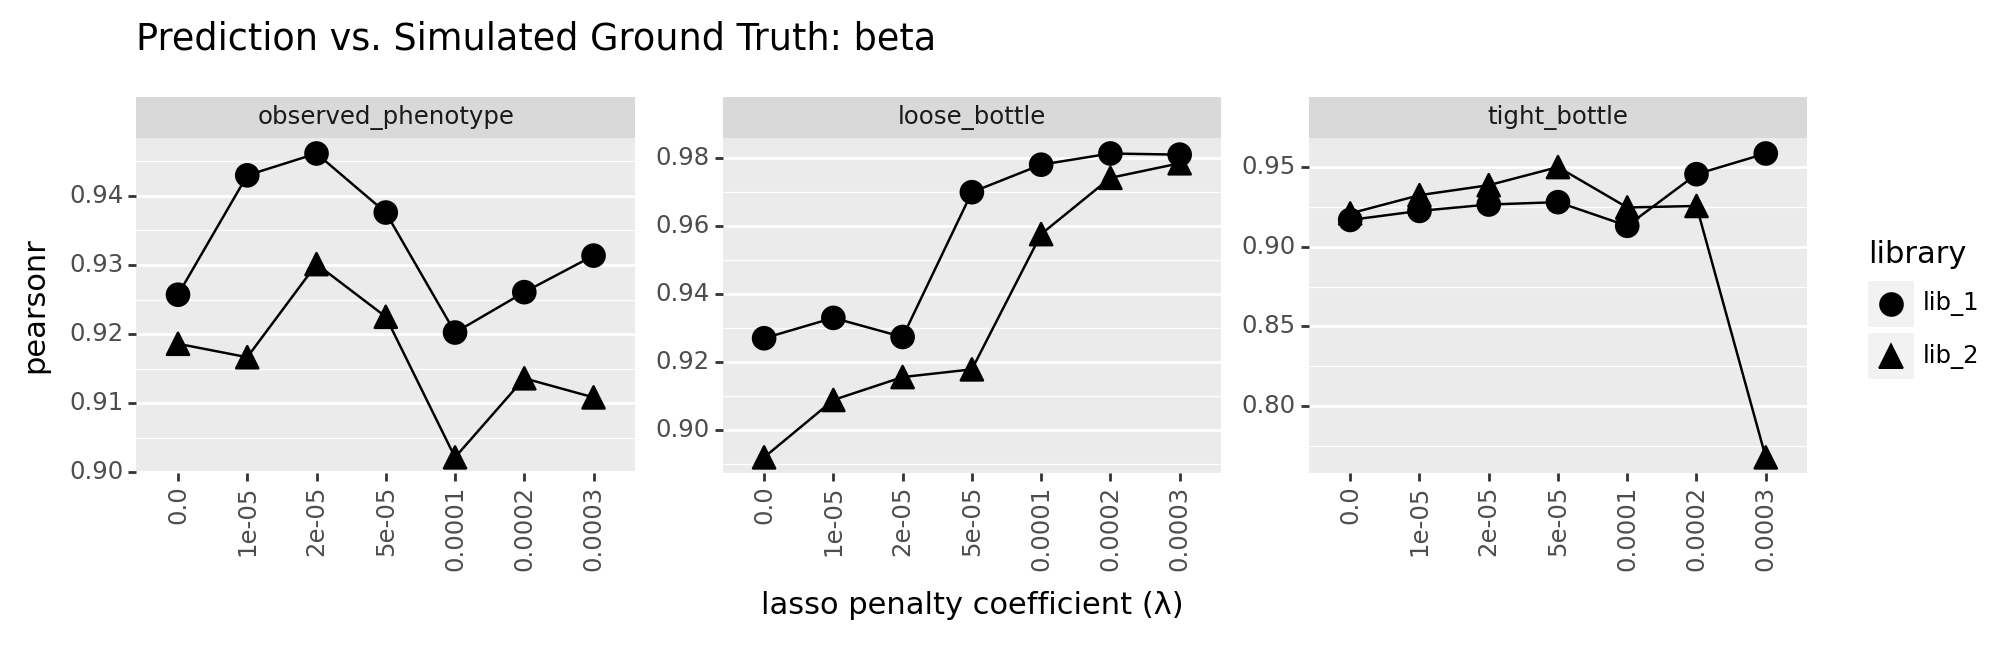

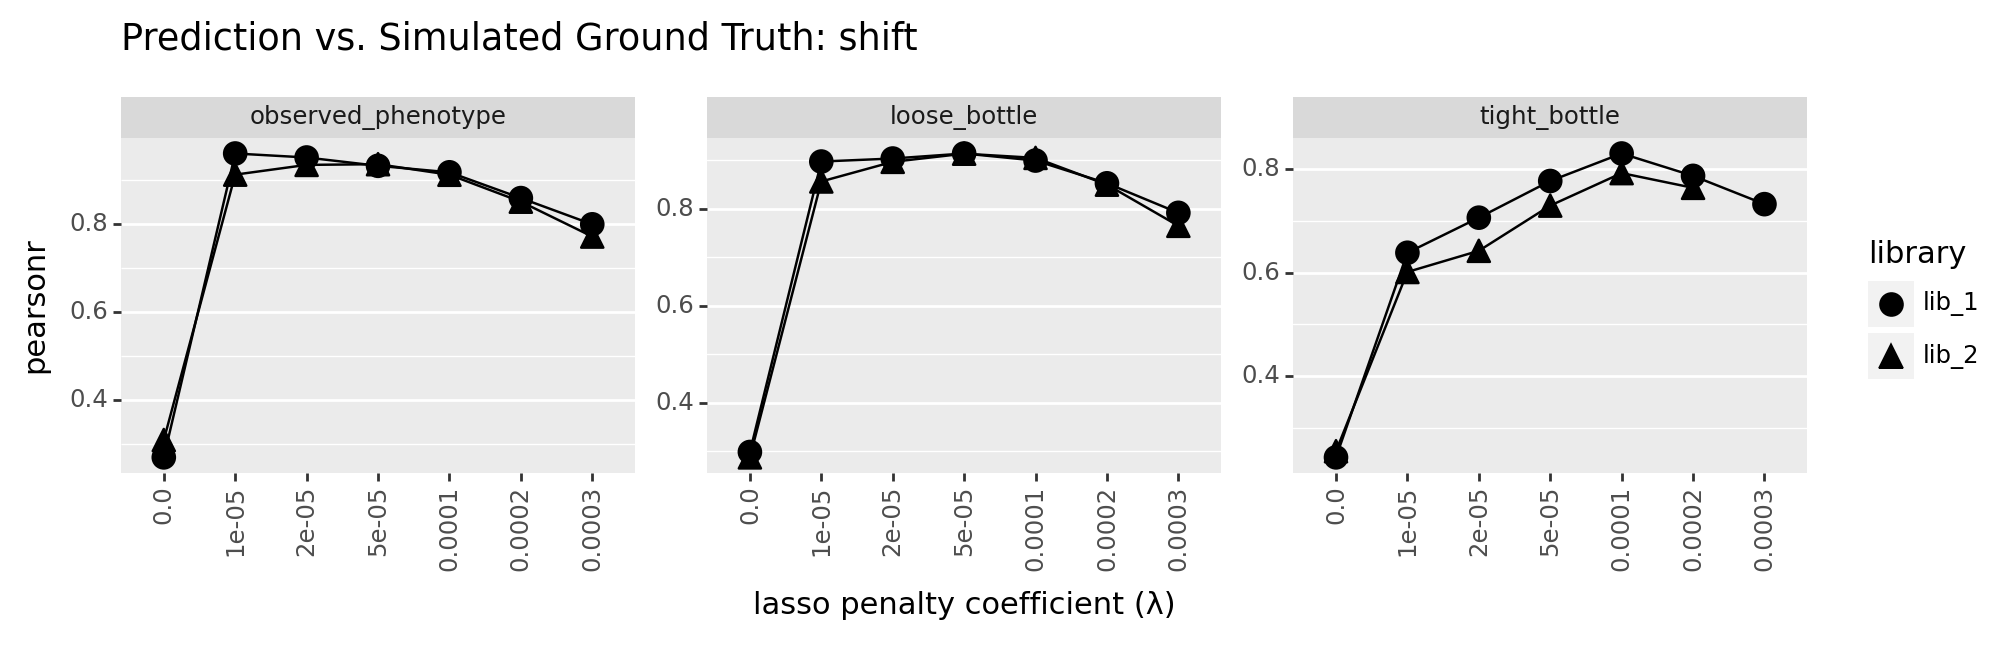

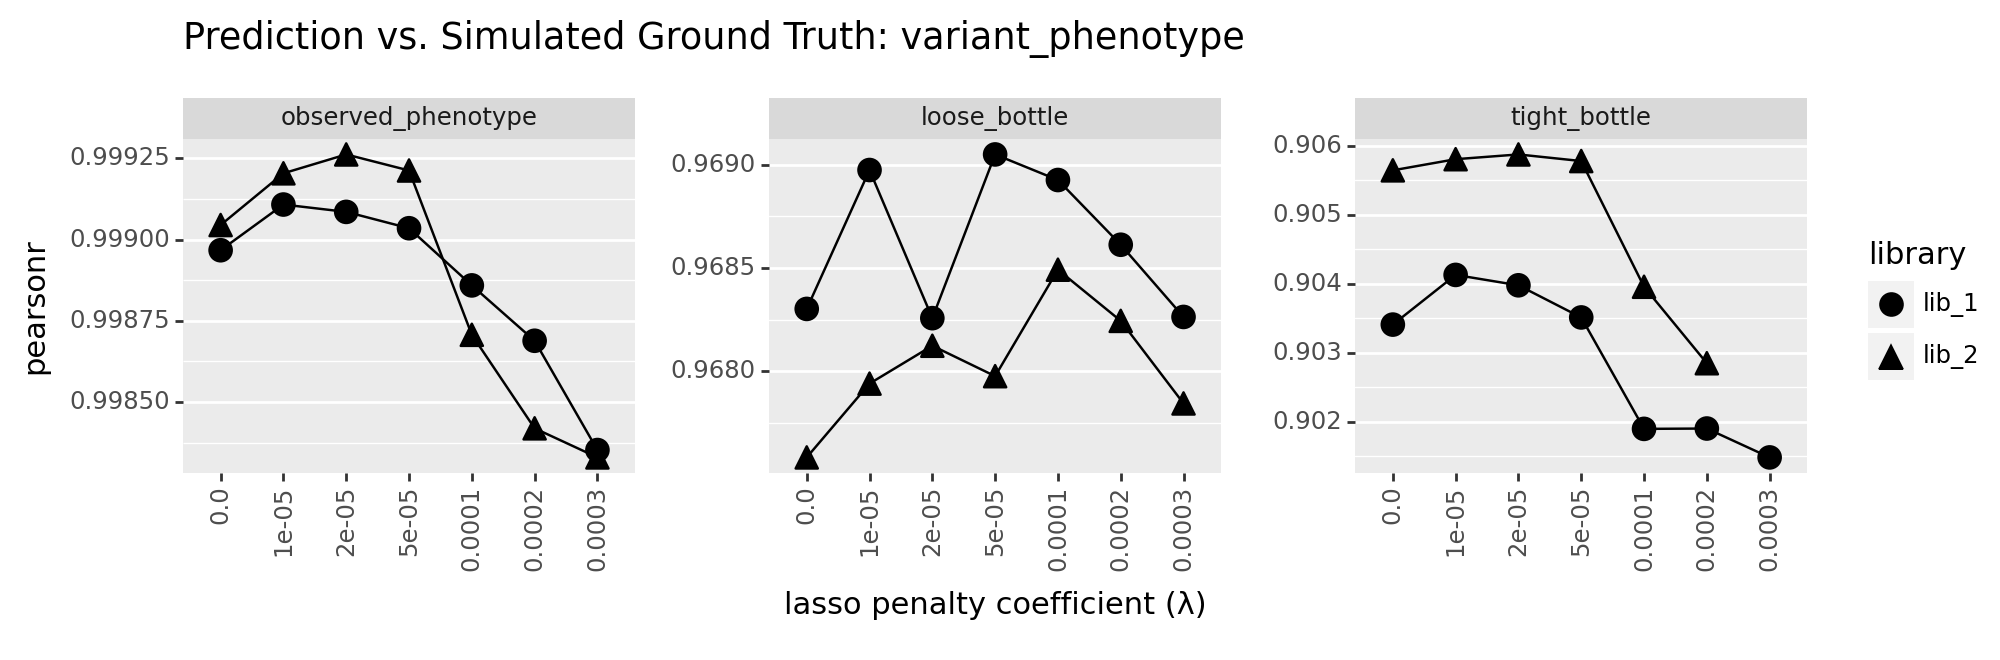

In [217]:
data = (
    fit_collection
    .assign(
        measurement_library = lambda x: x["measurement_type"].astype(str) + " " + x["library"]
    )
    .melt(
        id_vars=["scale_coeff_lasso_shift", "library", "measurement_type", "measurement_library"],
        value_vars=["beta_corr", "shift_corr", "variant_phenotype_corr"],
        var_name="parameter",
        value_name="correlation",
    )
)
data["parameter"] = data["parameter"].str.replace("_corr", "")
data["parameter"] = pd.Categorical(
    data["parameter"],
    categories=["beta", "shift", "variant_phenotype"],
    ordered=True
)
for parameter, parameter_df in data.groupby("parameter"):
    p = (
        ggplot(parameter_df)
        + geom_line(
            aes(
                x="scale_coeff_lasso_shift",
                y=f"correlation",
                group="measurement_library",
            ),
        )
        + geom_point(
            aes(
                x="scale_coeff_lasso_shift",
                y=f"correlation",
                # fill="library",
                shape="library"
            ),
            size=4
        )
        + scale_fill_manual(values=CBPALETTE[3:])
        # + scale_y_continuous(limits=[0.9, 1])
        + facet_wrap("measurement_type", scales="free_y")
        + theme(
            figure_size=(10, 3.3),
            axis_text_x=element_text(angle=90),
            panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        + labs(
            title=f"Prediction vs. Simulated Ground Truth: {parameter}",
            x="lasso penalty coefficient (λ)",
            y="pearsonr"
        )
    )
    _ = p.draw(show=True)

### Shift Sparsity

Another way we might evaluate the fits is by looking at the _sparsity_ of the models by computing the percentage of shift parameters that are equal to zero among the models. 



We look at this metric separately for mutations to stop codons and mutations to non-stop codons as we expect the stop codon mutations to act as a false positive control. This is because we expect the stop codons to be equally deleterious in both homologs, and thus we expect all the shift parameters for stop codon mutations to be zero.

In [190]:
# mc = multidms.model_collection.ModelCollection(fit_collection)

In [191]:
chart, shift_sparsity_df = mc.shift_sparsity(return_data=True)
spasity_chart_df

cache miss - this could take a moment


In [193]:
true_sparsity = 1 - mut_effects_df.shifted_site.mean()
true_sparsity

0.84

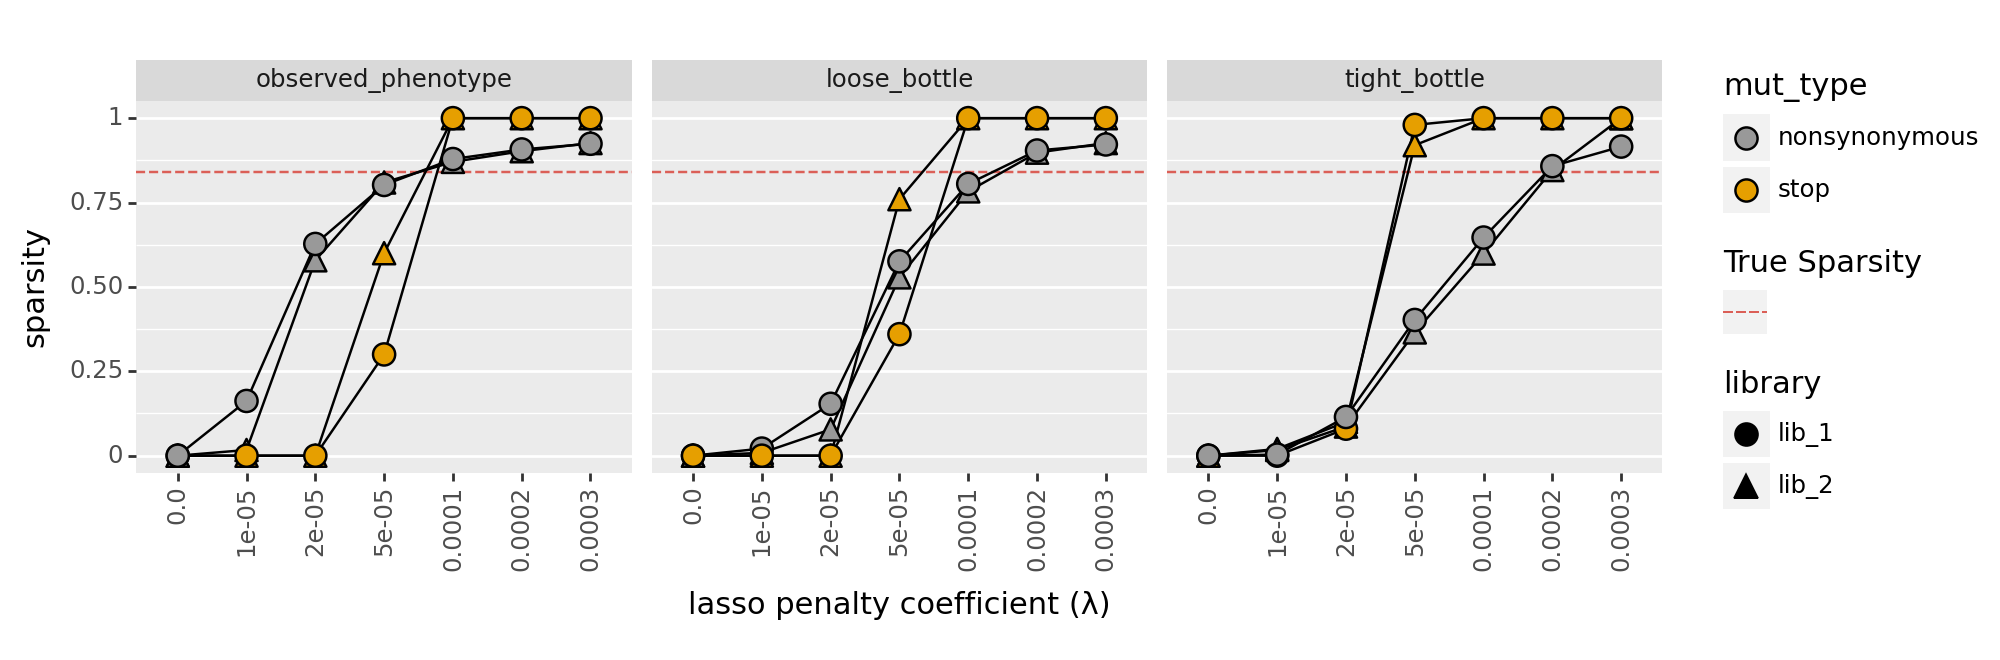

In [196]:
data =data.assign(
    library=data.dataset_name.str.split("_").str[:2].str.join("_"),
    library_type = data.dataset_name.str.split("_").str[:2].str.join("_") + "-" + data.mut_type,
    measurement_type = data.dataset_name.str.split("_").str[2:4].str.join("_")
)
# convert measurement type to categorical ordered by 'observed', 'loose', 'tight'
data["measurement_type"] = pd.Categorical(
    data["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)
data['True Sparsity'] = '' #dummy col for plotting legend
data.sort_values("scale_coeff_lasso_shift", inplace=True)
data["scale_coeff_lasso_shift"] = data.scale_coeff_lasso_shift.astype(object)
data.info()

p = (
    ggplot(
        data,
        aes("scale_coeff_lasso_shift", "sparsity")
    )
    + geom_hline(aes(yintercept=true_sparsity, color="True Sparsity"), linetype="dashed")
    + geom_line(
        aes(
            # x="scale_coeff_lasso_shift",
            # y=f"sparsity",
            group="library_type",
        ),
    )
    + geom_point(
        aes(
            # x="scale_coeff_lasso_shift",
            # y=f"sparsity",
            fill="mut_type",
            shape="library"
        ),
        size=4
    )
    + scale_fill_manual(values=CBPALETTE)
    # + scale_y_continuous(limits=[0.9, 1])
    + facet_wrap("measurement_type")
    + theme(
        figure_size=(10, 3.3),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + labs(
        title=f"",
        x="lasso penalty coefficient (λ)",
        y="sparsity"
    )
)
_ = p.draw(show=True)

### Correlation of libraries

In [184]:
from scipy.stats import pearsonr
from collections import defaultdict

In [185]:
library_correlations = defaultdict(list)
for measurement_type, lasso in itertools.product(
        ["observed_phenotype", "loose_bottle", "tight_bottle"], 
        model_collection_params["scale_coeff_lasso_shift"]
    ):
    query = f"(scale_coeff_lasso_shift == {lasso}) & (measurement_type == '{measurement_type}')"
    # get library replicate correlation of predicted beta, and shift from mutations_df subset
    library_correlations["measurement_type"].append(measurement_type)
    library_correlations["scale_coeff_lasso_shift"].append(lasso)

    # mutations dataframe
    wide_mutation_data = (
        mutations_df
        .query(query)
        [["mutation", "library", "predicted_beta", "predicted_shift_h2"]]
        .pivot_table(
            index=["mutation"],
            columns="library",
            values=["predicted_beta", "predicted_shift_h2"]
        )
    )
    library_correlations["beta"].append(wide_mutation_data["predicted_beta"].corr().iloc[0, 1])
    library_correlations["shift"].append(wide_mutation_data["predicted_shift_h2"].corr().iloc[0, 1])

    # now for the variants dataframe
    wide_variant_data = (
        variants_df
        .query(query)
        [["aa_substitutions", "library", "predicted_phenotype"]]
        .pivot_table(
            index=["aa_substitutions"],
            columns="library",
            values="predicted_phenotype"
        )
    )
    library_correlations["phenotype"].append(wide_variant_data.corr().iloc[0, 1])

library_correlations_df = pd.DataFrame(library_correlations)
library_correlations_df["scale_coeff_lasso_shift"] = library_correlations_df["scale_coeff_lasso_shift"].astype(object)
library_correlations_df["measurement_type"] = pd.Categorical(
    library_correlations_df["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)
library_correlations_df

measurement_type scale_coeff_lasso_shift      beta     shift  phenotype
0   observed_phenotype                     0.0  0.950480  0.800121   0.999364
1   observed_phenotype                 0.00001  0.956013  0.910727   0.999536
2   observed_phenotype                 0.00002  0.962939  0.975287   0.999671
3   observed_phenotype                 0.00005  0.959503  0.985717   0.999565
4   observed_phenotype                  0.0001  0.941029  0.967927   0.999189
5   observed_phenotype                  0.0002  0.946818  0.938622   0.999116
6   observed_phenotype                  0.0003  0.953214  0.912138   0.999296
7         loose_bottle                     0.0  0.923670  0.684788   0.997400
8         loose_bottle                 0.00001  0.927239  0.781557   0.997616
9         loose_bottle                 0.00002  0.941259  0.868631   0.998661
10        loose_bottle                 0.00005  0.924912  0.935156   0.997673
11        loose_bottle                  0.0001  0.954349  0.946289   0.998703
12        loose_bottle                  0.0002  0.966925  0.925330   0.998801
13        loose_bottle                  0.0003  0.970358  0.908584   0.998734
14        tight_bottle                     0.0  0.909342  0.372995   0.994416
15        tight_bottle                 0.00001  0.895016  0.380966   0.994008
16        tight_bottle                 0.00002  0.900558  0.468923   0.994653
17        tight_bottle                 0.00005  0.908104  0.630486   0.995736
18        tight_bottle                  0.0001  0.905349  0.761342   0.995224
19        tight_bottle                  0.0002  0.897009  0.800254   0.994752
20        tight_bottle                  0.0003  0.727618       NaN        NaN

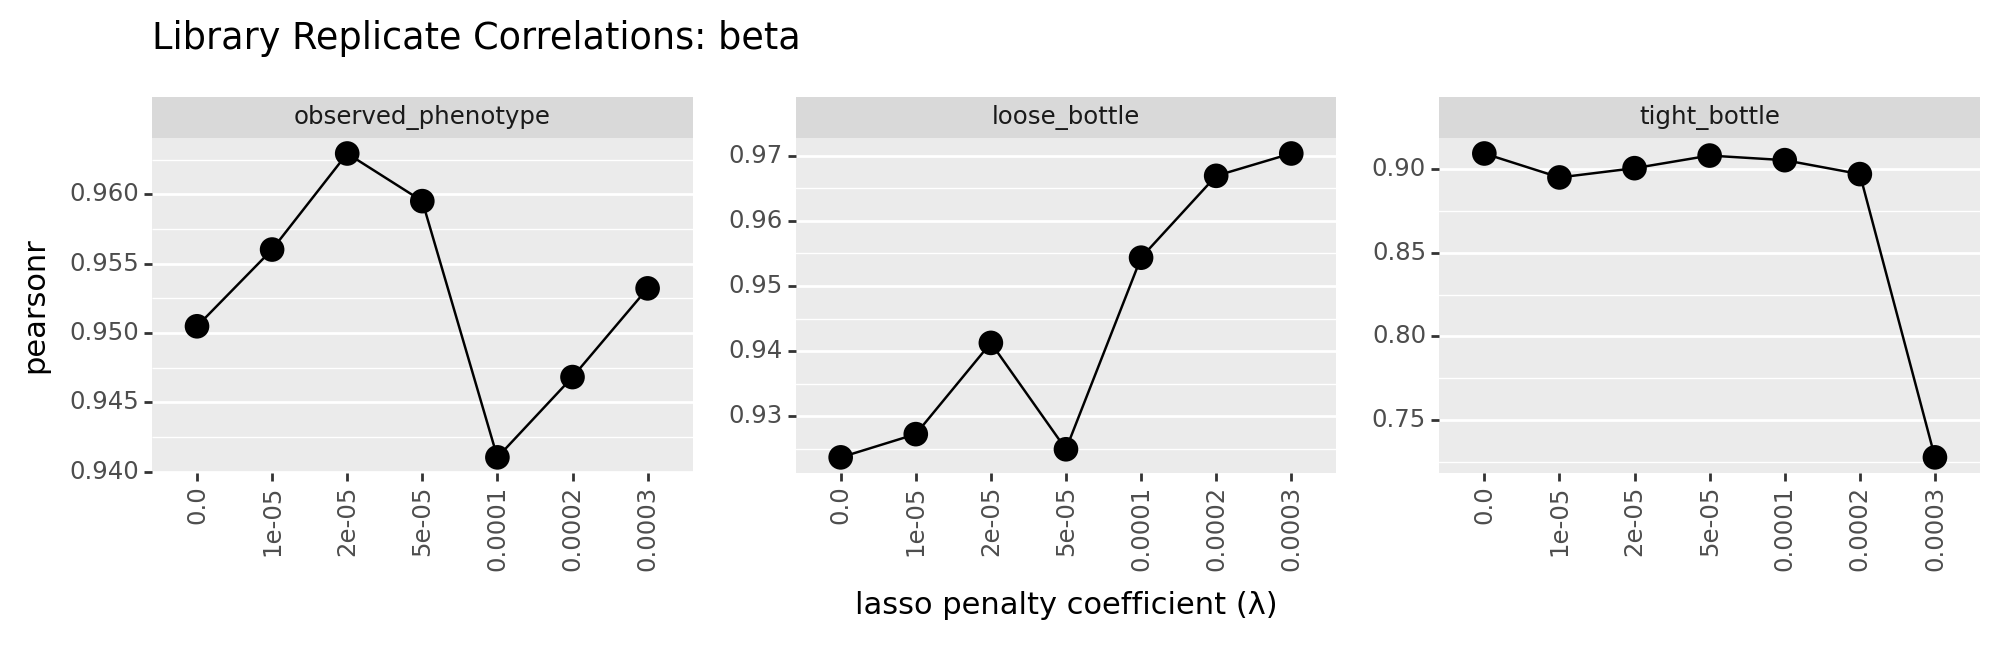

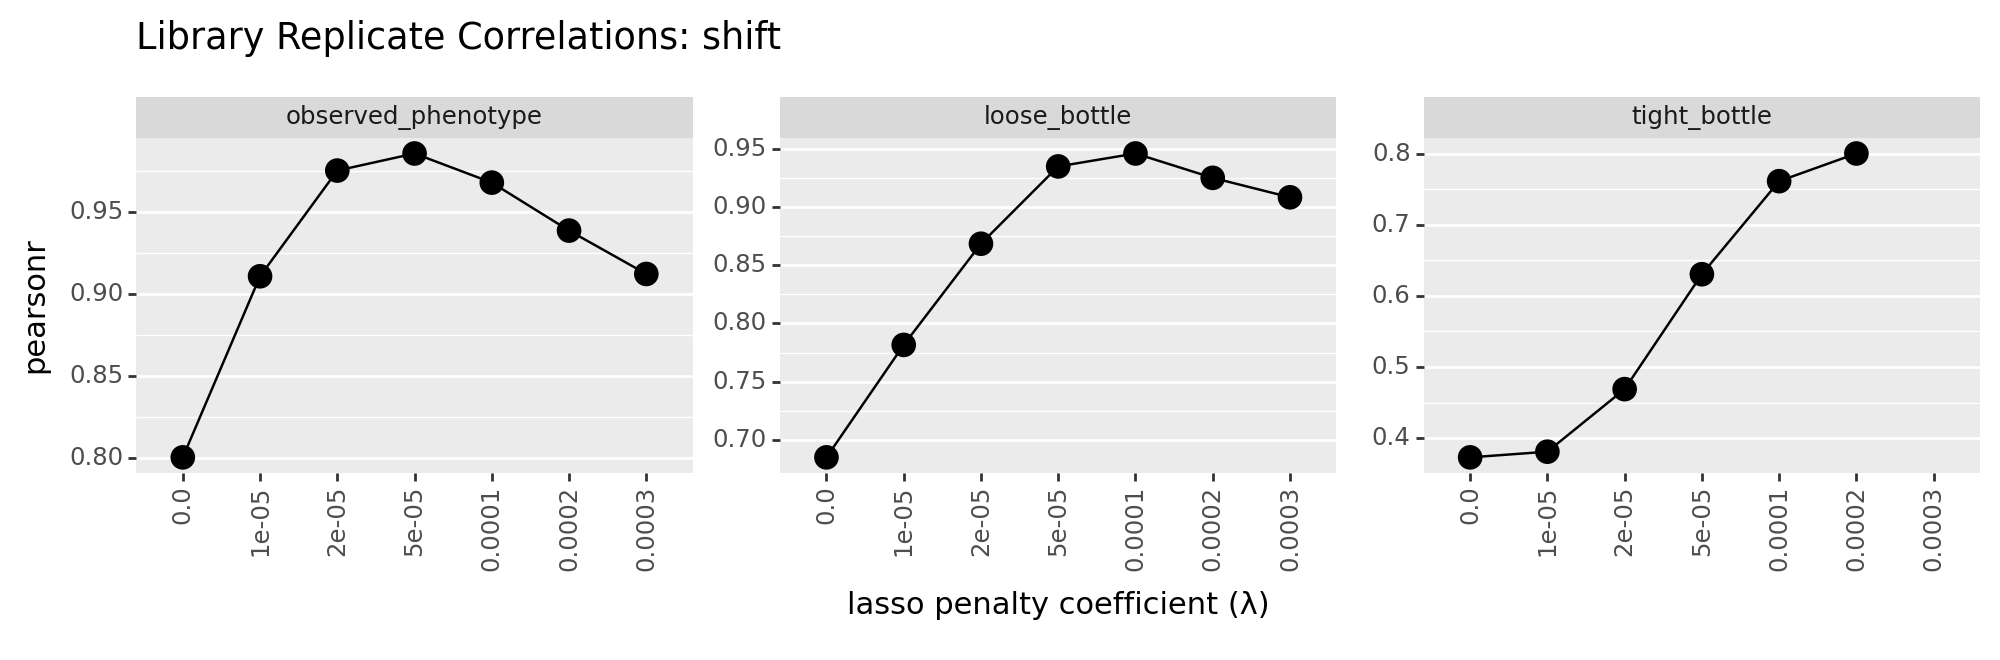

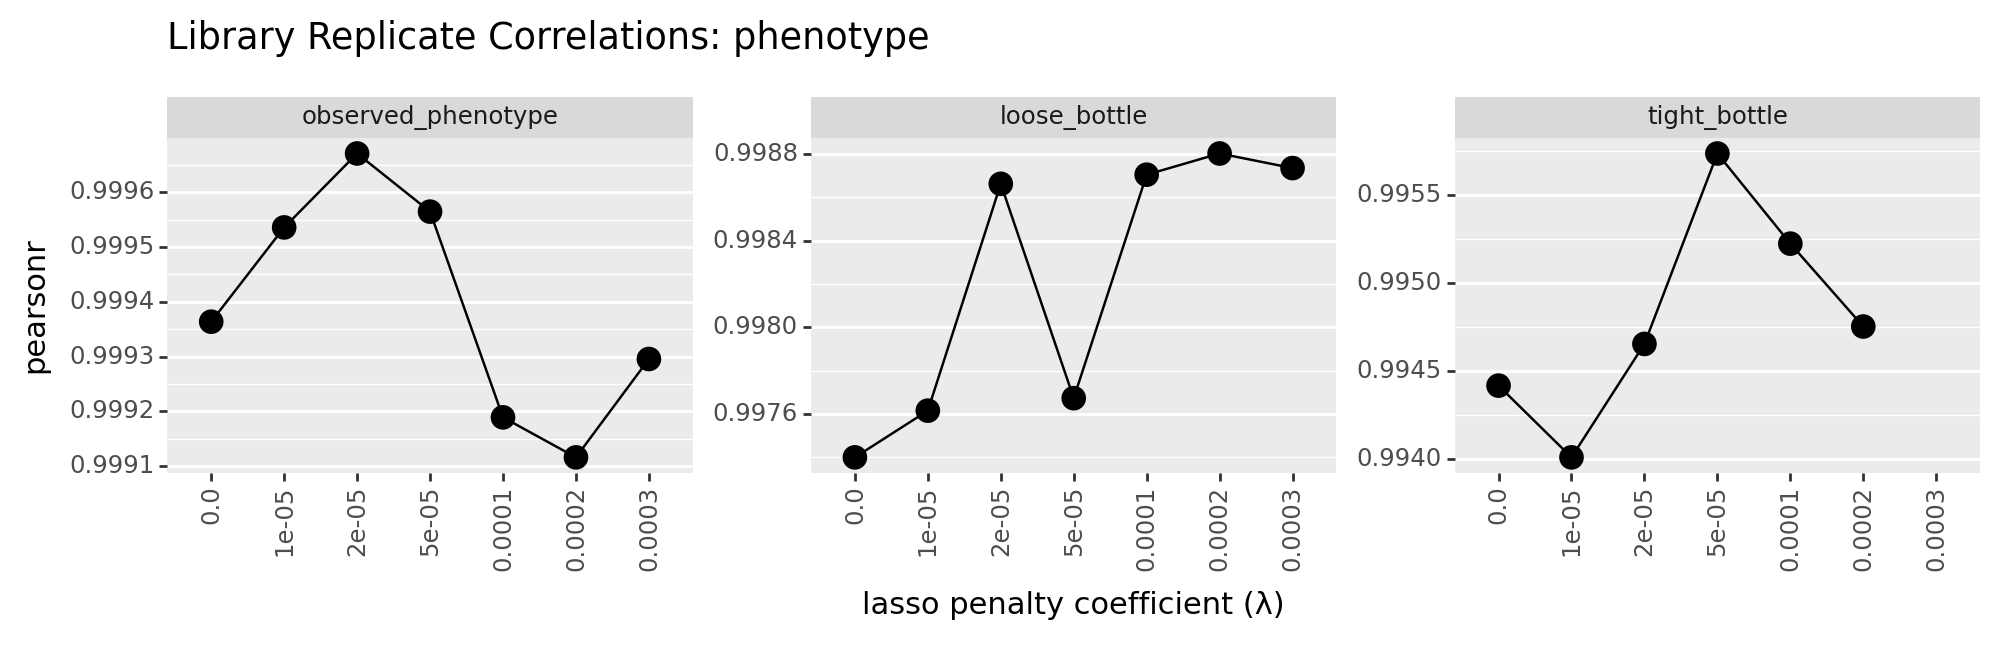

In [186]:
data = (
    library_correlations_df
    .melt(
        id_vars=["scale_coeff_lasso_shift", "measurement_type"],
        value_vars=["beta", "shift", "phenotype"],
        var_name="parameter",
        value_name="correlation"
    )
)
data["parameter"] = pd.Categorical(
    data["parameter"],
    categories=["beta", "shift", "phenotype"],
    ordered=True
)
for parameter, parameter_df in data.groupby("parameter"):
    p = (
        ggplot(
            parameter_df
        )
        + geom_line(
            aes(
                x="scale_coeff_lasso_shift",
                y="correlation",
                group="measurement_type"
            ),
        )
        + geom_point(
            aes(
                x="scale_coeff_lasso_shift",
                y="correlation",
                # fill="measurement_type"
            ),
            size=4
        )
        + facet_wrap("measurement_type", scales="free_y")
        + theme(
            figure_size=(10, 3.3),
            axis_text_x=element_text(angle=90),
            panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        + labs(
            title=f"Library Replicate Correlations: {parameter}",
            x="lasso penalty coefficient (λ)",
            y="pearsonr"
        )
    )
    _ = p.draw(show=True)

### Cross validation

We would like to know if cross validation can help us select the best model. We can do this by breaking the variant data into a training and test set, and then fitting the model to the training set and evaluating the model on the test set. 

In [200]:
train, test = [], {}
for (library, measurement), fs_df in func_scores.groupby(["library", "func_score_type"]):
    
    if "enrichment" in measurement:
        continue

    print(library, measurement)
    dataset = fs_df.sample(frac=1, random_state=seed)
    train_split, test_split = dataset.iloc[:int(len(dataset) * 0.8)], dataset.iloc[int(len(dataset) * 0.8):]
    name = f"{library}_{measurement}"
    
    train.append(
        multidms.Data(
            train_split, 
            reference="h1", 
            alphabet = multidms.AAS_WITHSTOP_WITHGAP, 
            verbose=False,
            name = name
        )
    )

    test[name] = test_split

lib_1 loose_bottle
lib_1 observed_phenotype
lib_1 tight_bottle
lib_2 loose_bottle
lib_2 observed_phenotype
lib_2 tight_bottle


In [201]:
fitting_params["dataset"] = train 
# _, _, fit_collection = multidms.model_collection.fit_models(fitting_params)

In [ ]:


fit_collection = pickle.load(open("train_fit_collection.pkl", "rb"))

In [ ]:
mc = multidms.model_collection.ModelCollection(fit_collection)
mc.add_validation_loss(test)

In [204]:
fit_collection = mc.fit_models
fit_collection.head()

model        dataset_name  \
0  Model(Model-0)  lib_1_loose_bottle   
1  Model(Model-1)  lib_1_loose_bottle   
2  Model(Model-2)  lib_1_loose_bottle   
3  Model(Model-0)  lib_1_loose_bottle   
4  Model(Model-1)  lib_1_loose_bottle   

                                  step_loss epistatic_model output_activation  \
0  [7.742283462844756, 0.34388165791551767]         Sigmoid          Identity   
1   [7.742283462844756, 0.3441381394239146]         Sigmoid          Identity   
2  [7.742283462844756, 0.34441909962684975]         Sigmoid          Identity   
3  [7.742283462844756, 0.34545855292353556]         Sigmoid          Identity   
4  [7.742283462844756, 0.34660898161660797]         Sigmoid          Identity   

  scale_coeff_lasso_shift scale_coeff_ridge_beta scale_coeff_ridge_shift  \
0                     0.0                    0.0                       0   
1                 0.00001                    0.0                       0   
2                 0.00002                    0.0                       0   
3                 0.00005                    0.0                       0   
4                  0.0001                    0.0                       0   

  scale_coeff_ridge_gamma scale_coeff_ridge_alpha_d  ... init_beta_naught  \
0                       0                         0  ...              5.0   
1                       0                         0  ...              5.0   
2                       0                         0  ...              5.0   
3                       0                         0  ...              5.0   
4                       0                         0  ...              5.0   

  lock_beta_naught_at     tol num_training_steps iterations_per_step  \
0                None  0.0001                  1               10000   
1                None  0.0001                  1               10000   
2                None  0.0001                  1               10000   
3                None  0.0001                  1               10000   
4                None  0.0001                  1               10000   

  n_hidden_units lower_bound PRNGKey final_loss validation_loss  
0              5        None       0   0.343882        0.371462  
1              5        None       0   0.344138        0.366787  
2              5        None       0   0.344419        0.364352  
3              5        None       0   0.345459        0.360019  
4              5        None       0   0.346609        0.356921  

[5 rows x 23 columns]

In [205]:
fit_collection["training_loss"] = [float(row.model.loss) for _, row in fit_collection.iterrows()]
fit_collection["measurement_type"] = fit_collection["dataset_name"].str.split("_").str[2:4].str.join("_")
fit_collection["library"] = fit_collection["dataset_name"].str.split("_").str[0:2].str.join("_")
# convert measurement type to categorical ordered by 'observed', 'loose', 'tight'
fit_collection["measurement_type"] = pd.Categorical(
    fit_collection["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)
fit_collection.head()

model        dataset_name  \
0  Model(Model-0)  lib_1_loose_bottle   
1  Model(Model-1)  lib_1_loose_bottle   
2  Model(Model-2)  lib_1_loose_bottle   
3  Model(Model-0)  lib_1_loose_bottle   
4  Model(Model-1)  lib_1_loose_bottle   

                                  step_loss epistatic_model output_activation  \
0  [7.742283462844756, 0.34388165791551767]         Sigmoid          Identity   
1   [7.742283462844756, 0.3441381394239146]         Sigmoid          Identity   
2  [7.742283462844756, 0.34441909962684975]         Sigmoid          Identity   
3  [7.742283462844756, 0.34545855292353556]         Sigmoid          Identity   
4  [7.742283462844756, 0.34660898161660797]         Sigmoid          Identity   

  scale_coeff_lasso_shift scale_coeff_ridge_beta scale_coeff_ridge_shift  \
0                     0.0                    0.0                       0   
1                 0.00001                    0.0                       0   
2                 0.00002                    0.0                       0   
3                 0.00005                    0.0                       0   
4                  0.0001                    0.0                       0   

  scale_coeff_ridge_gamma scale_coeff_ridge_alpha_d  ... num_training_steps  \
0                       0                         0  ...                  1   
1                       0                         0  ...                  1   
2                       0                         0  ...                  1   
3                       0                         0  ...                  1   
4                       0                         0  ...                  1   

  iterations_per_step n_hidden_units lower_bound PRNGKey final_loss  \
0               10000              5        None       0   0.343882   
1               10000              5        None       0   0.344138   
2               10000              5        None       0   0.344419   
3               10000              5        None       0   0.345459   
4               10000              5        None       0   0.346609   

  validation_loss training_loss measurement_type library  
0        0.371462      0.343882     loose_bottle   lib_1  
1        0.366787      0.344138     loose_bottle   lib_1  
2        0.364352      0.344419     loose_bottle   lib_1  
3        0.360019      0.345459     loose_bottle   lib_1  
4        0.356921      0.346609     loose_bottle   lib_1  

[5 rows x 26 columns]

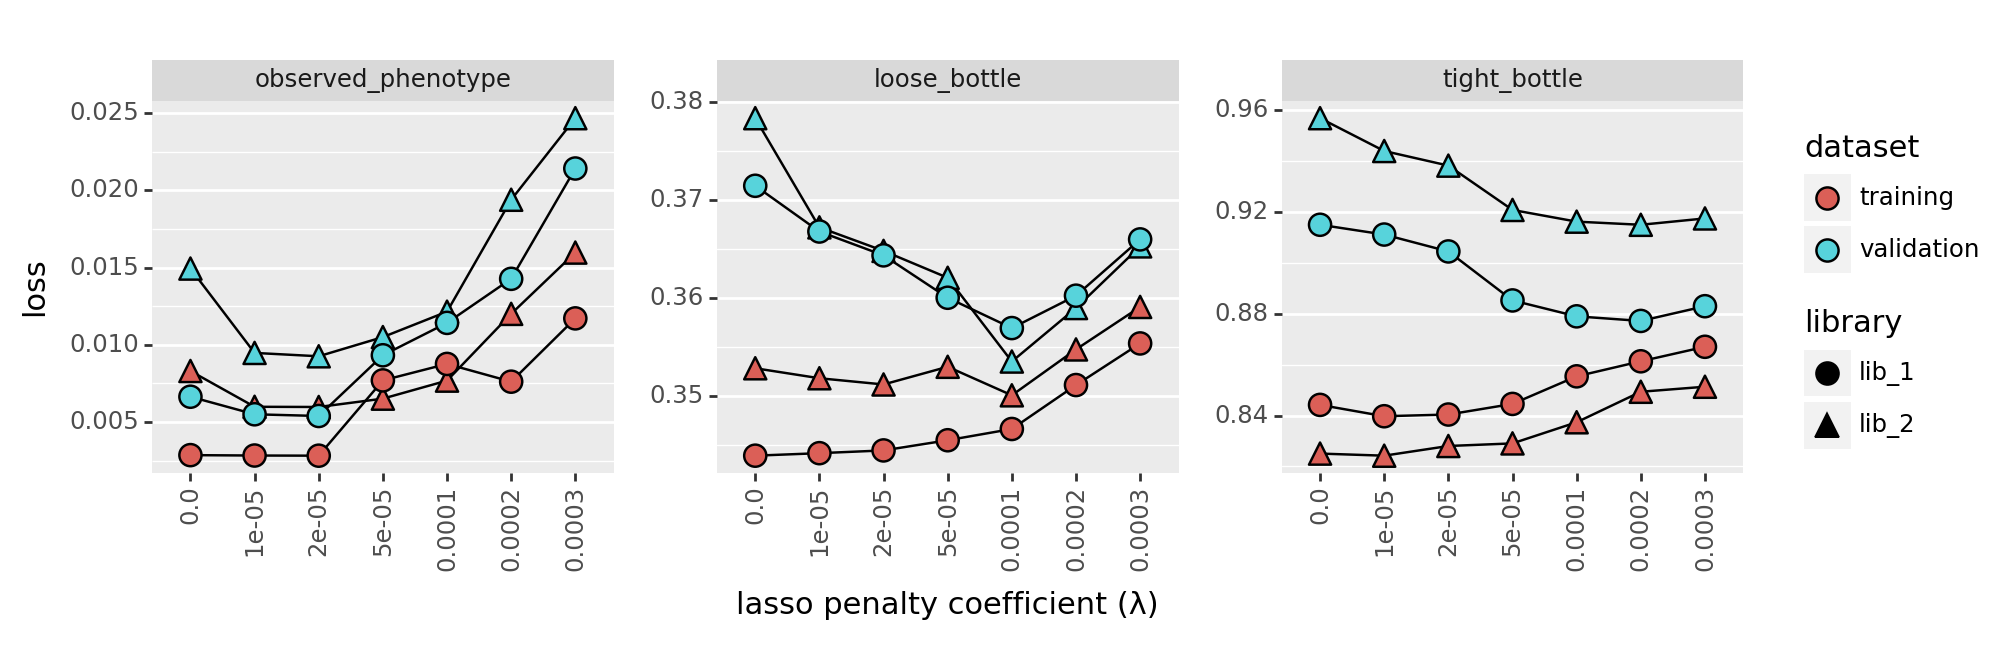

In [207]:
data = (
    fit_collection
    .melt(
        id_vars=["scale_coeff_lasso_shift", "library", "measurement_type"],
        value_vars=["training_loss", "validation_loss"],
        var_name="dataset",
        value_name="loss",
    )
    .assign(
        dataset = lambda x: x["dataset"].str.replace("_loss", "")
    )
    .assign(
        lib_dataset = lambda x: x["library"] + " " + x["dataset"]
    )
)
p = (
    ggplot(data)
    + geom_line(
        aes(
            x="scale_coeff_lasso_shift",
            y=f"loss",
            group="lib_dataset",
        )
    )
    + geom_point(
        aes(
            x="scale_coeff_lasso_shift",
            y=f"loss",
            fill="dataset",
            shape="library"
        ),
        size=4
    )
    + facet_wrap("measurement_type", scales="free_y")
    + theme(
        figure_size=(10, 3.3),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + labs(
        x="lasso penalty coefficient (λ)",
        y="loss"
    )
)
_ = p.draw(show=True)

### Singular Model Evaluation

Using the model selection criterias for sparsity, library replicate correlation, and cross validation, we can select the best model and take a closer look at the predictions of the best model for each of the noise levels.

In [79]:
lasso = 1e-4

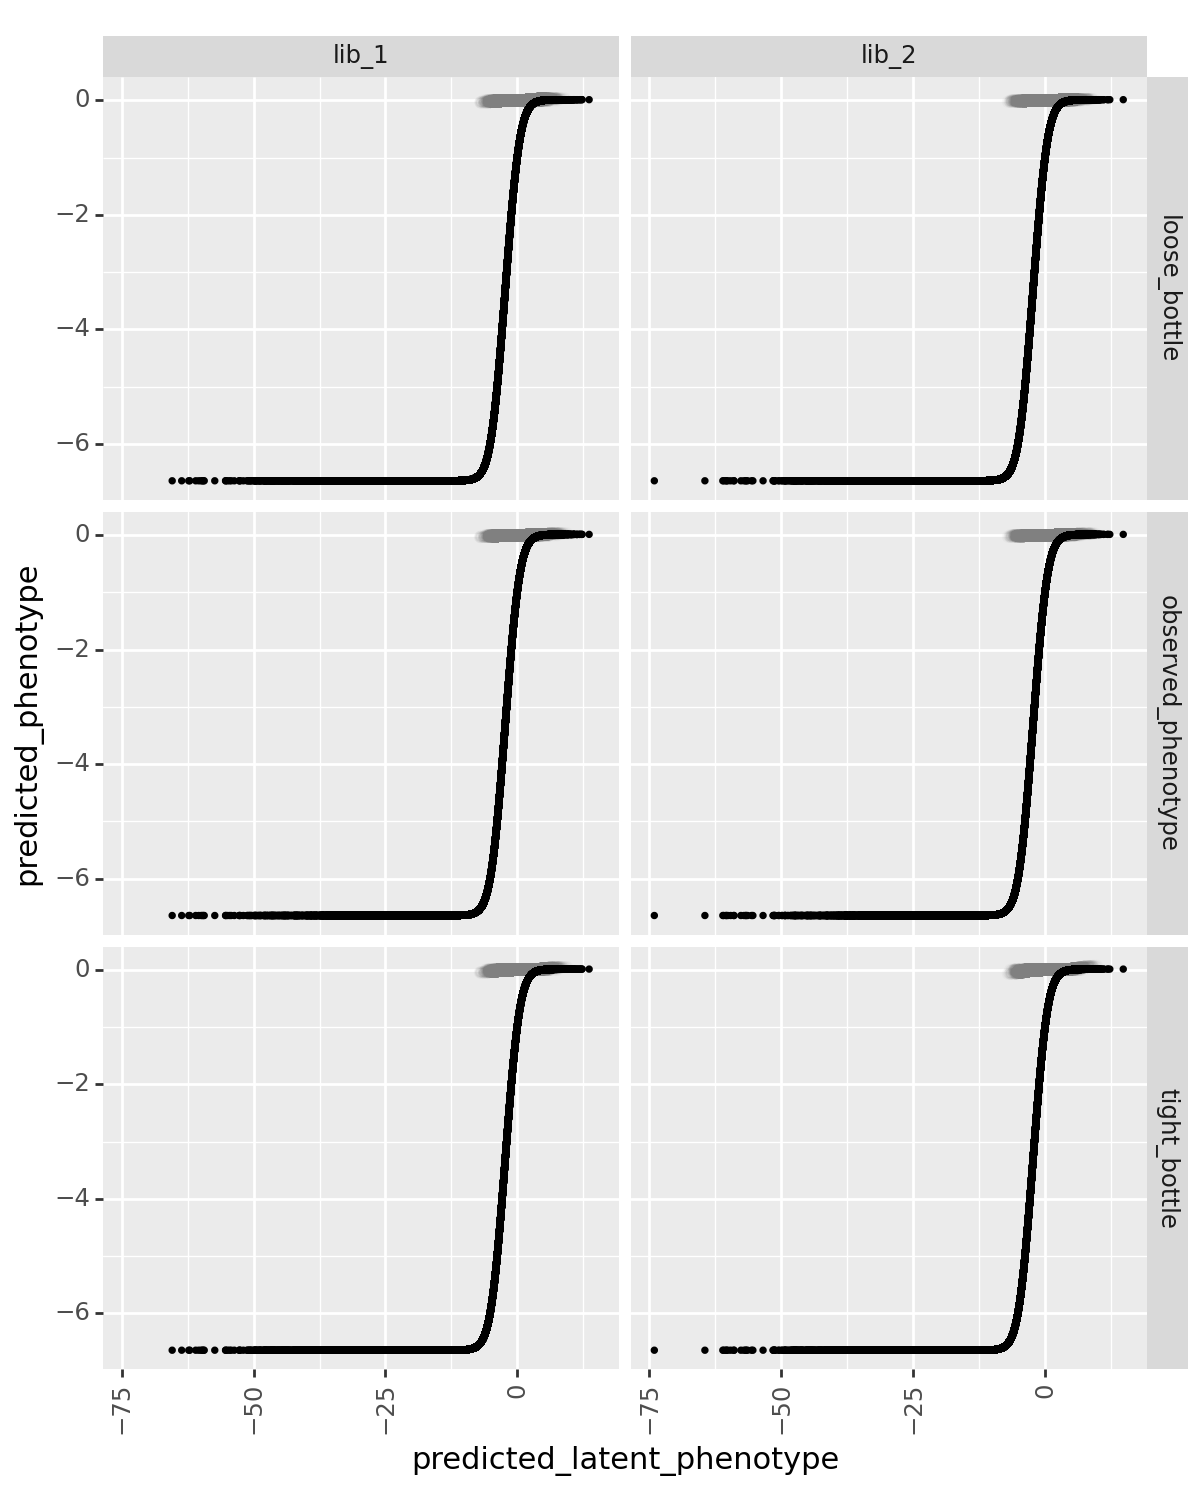

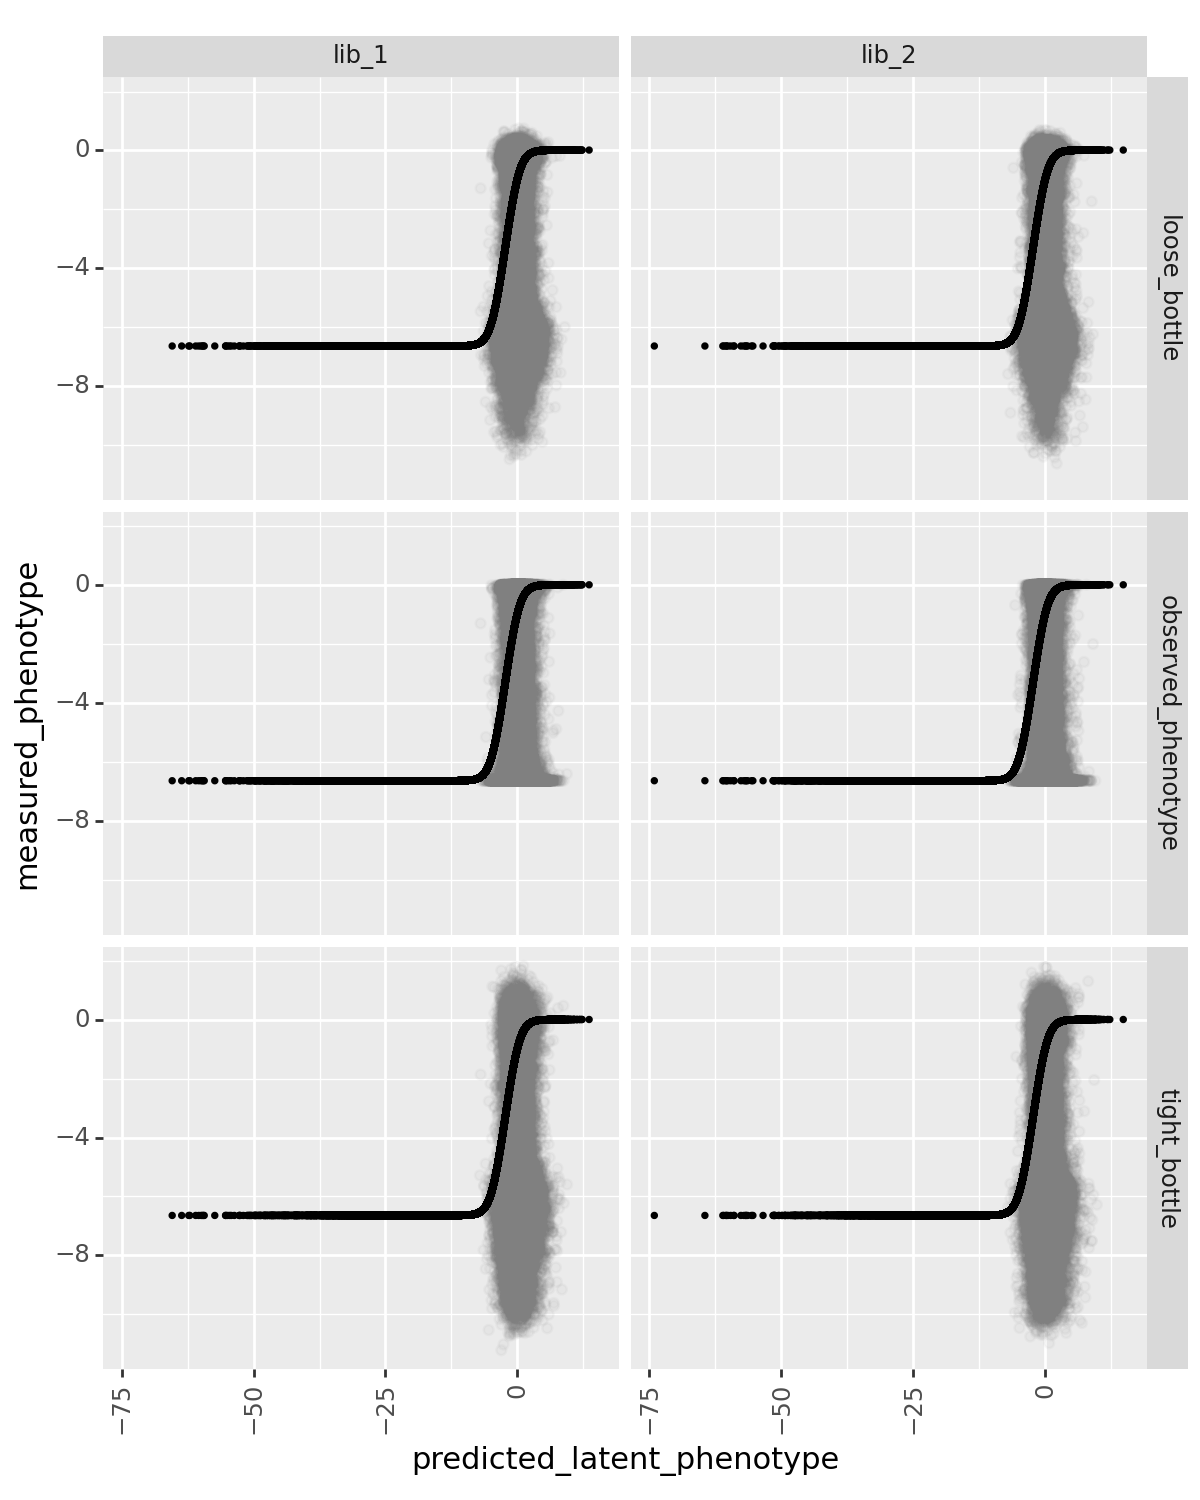

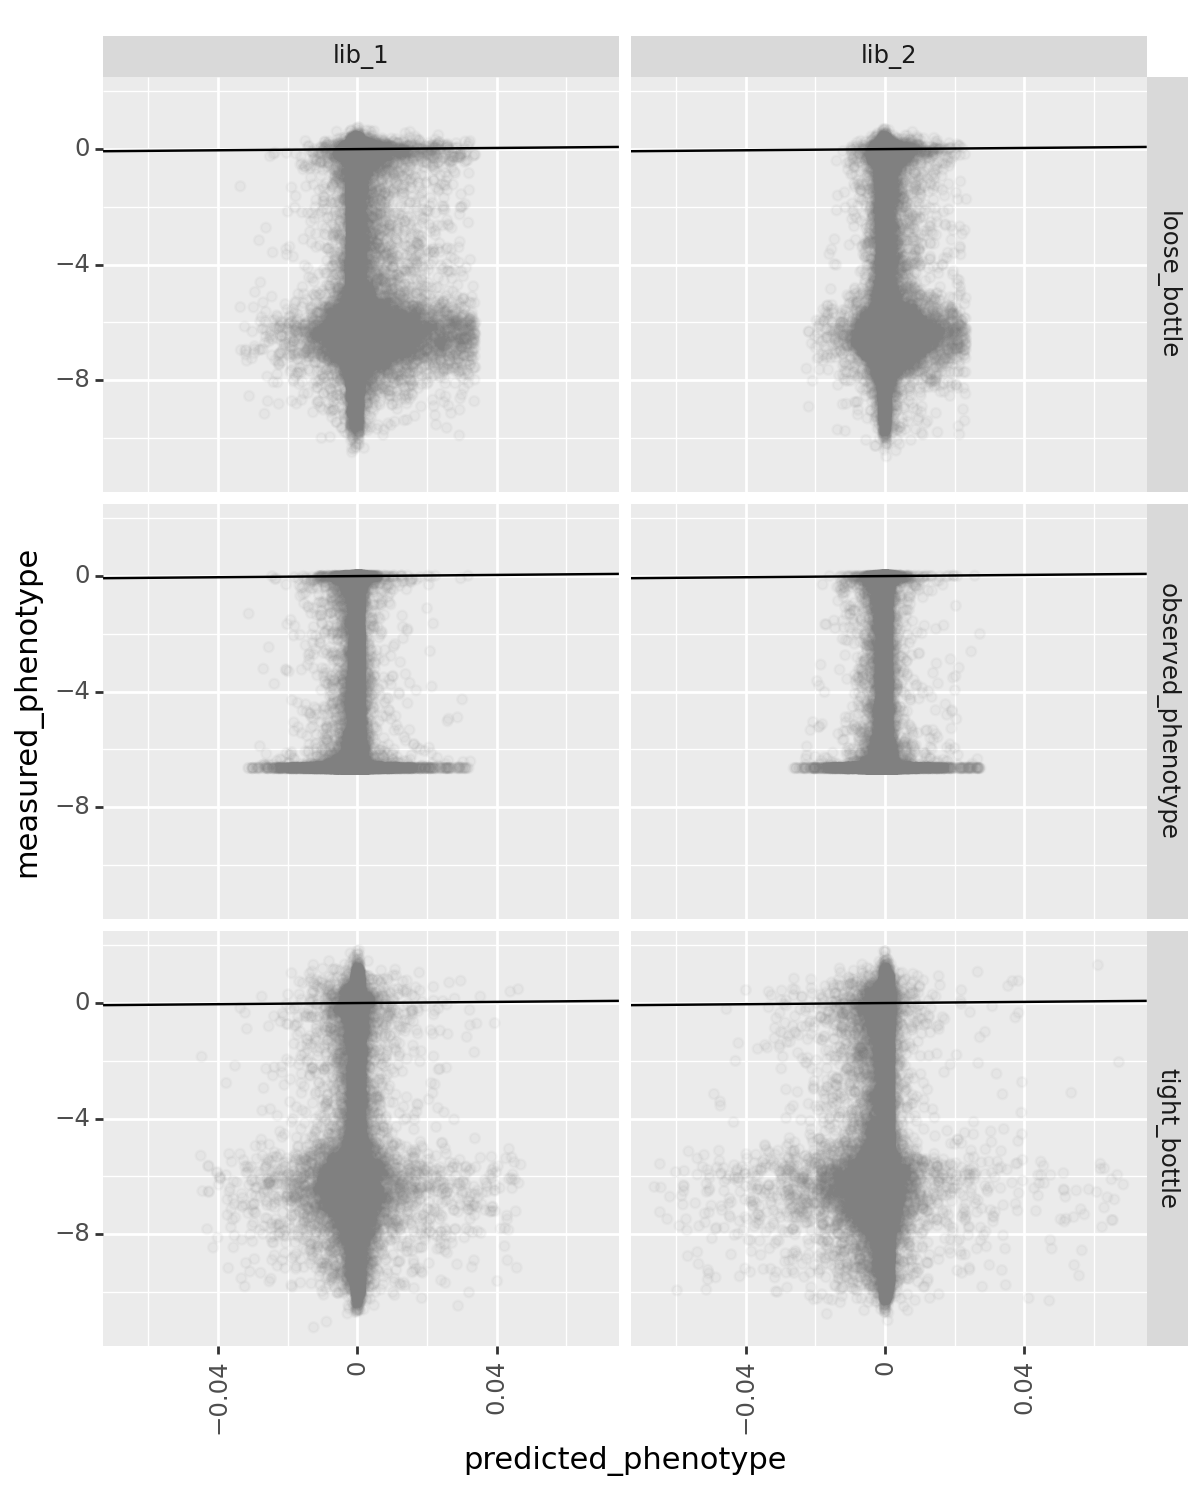

In [80]:

data = variants_df.query(f"scale_coeff_lasso_shift == {lasso}")
for x, y in itertools.combinations(
    ["predicted_latent_phenotype", "predicted_phenotype", "measured_phenotype"], 2
):
    p = (
        ggplot(data.sample(frac=1.0))
        + geom_point(
            aes(
                x=x,
                y=y    
            ),
            alpha=0.05,
            color="grey"
        )
        # ground truth 
        + ylab(y)
        + xlab(x)
        + facet_grid("measurement_type ~ library")
        + theme(
            figure_size=(3 * len(libs), 2.5 * len(data["measurement_type"].unique())),
            axis_text_x=element_text(angle=90),
        )
    )

    if x == "predicted_latent_phenotype":
        p+= geom_point(
            aes(
                x="true_latent_phenotype",
                y="true_observed_phenotype"
            ),
            size=0.5,
        )
    else:
        p += geom_abline(
            slope=1,
            intercept=0, 
        )

    
        
    _ = p.draw(show=True)

Overall these look very similar to the simulated sigmoid. Note that both the homolog conditions share the same sigmoid, and there is no latent offset ($\alpha_d$) parameter in these models.

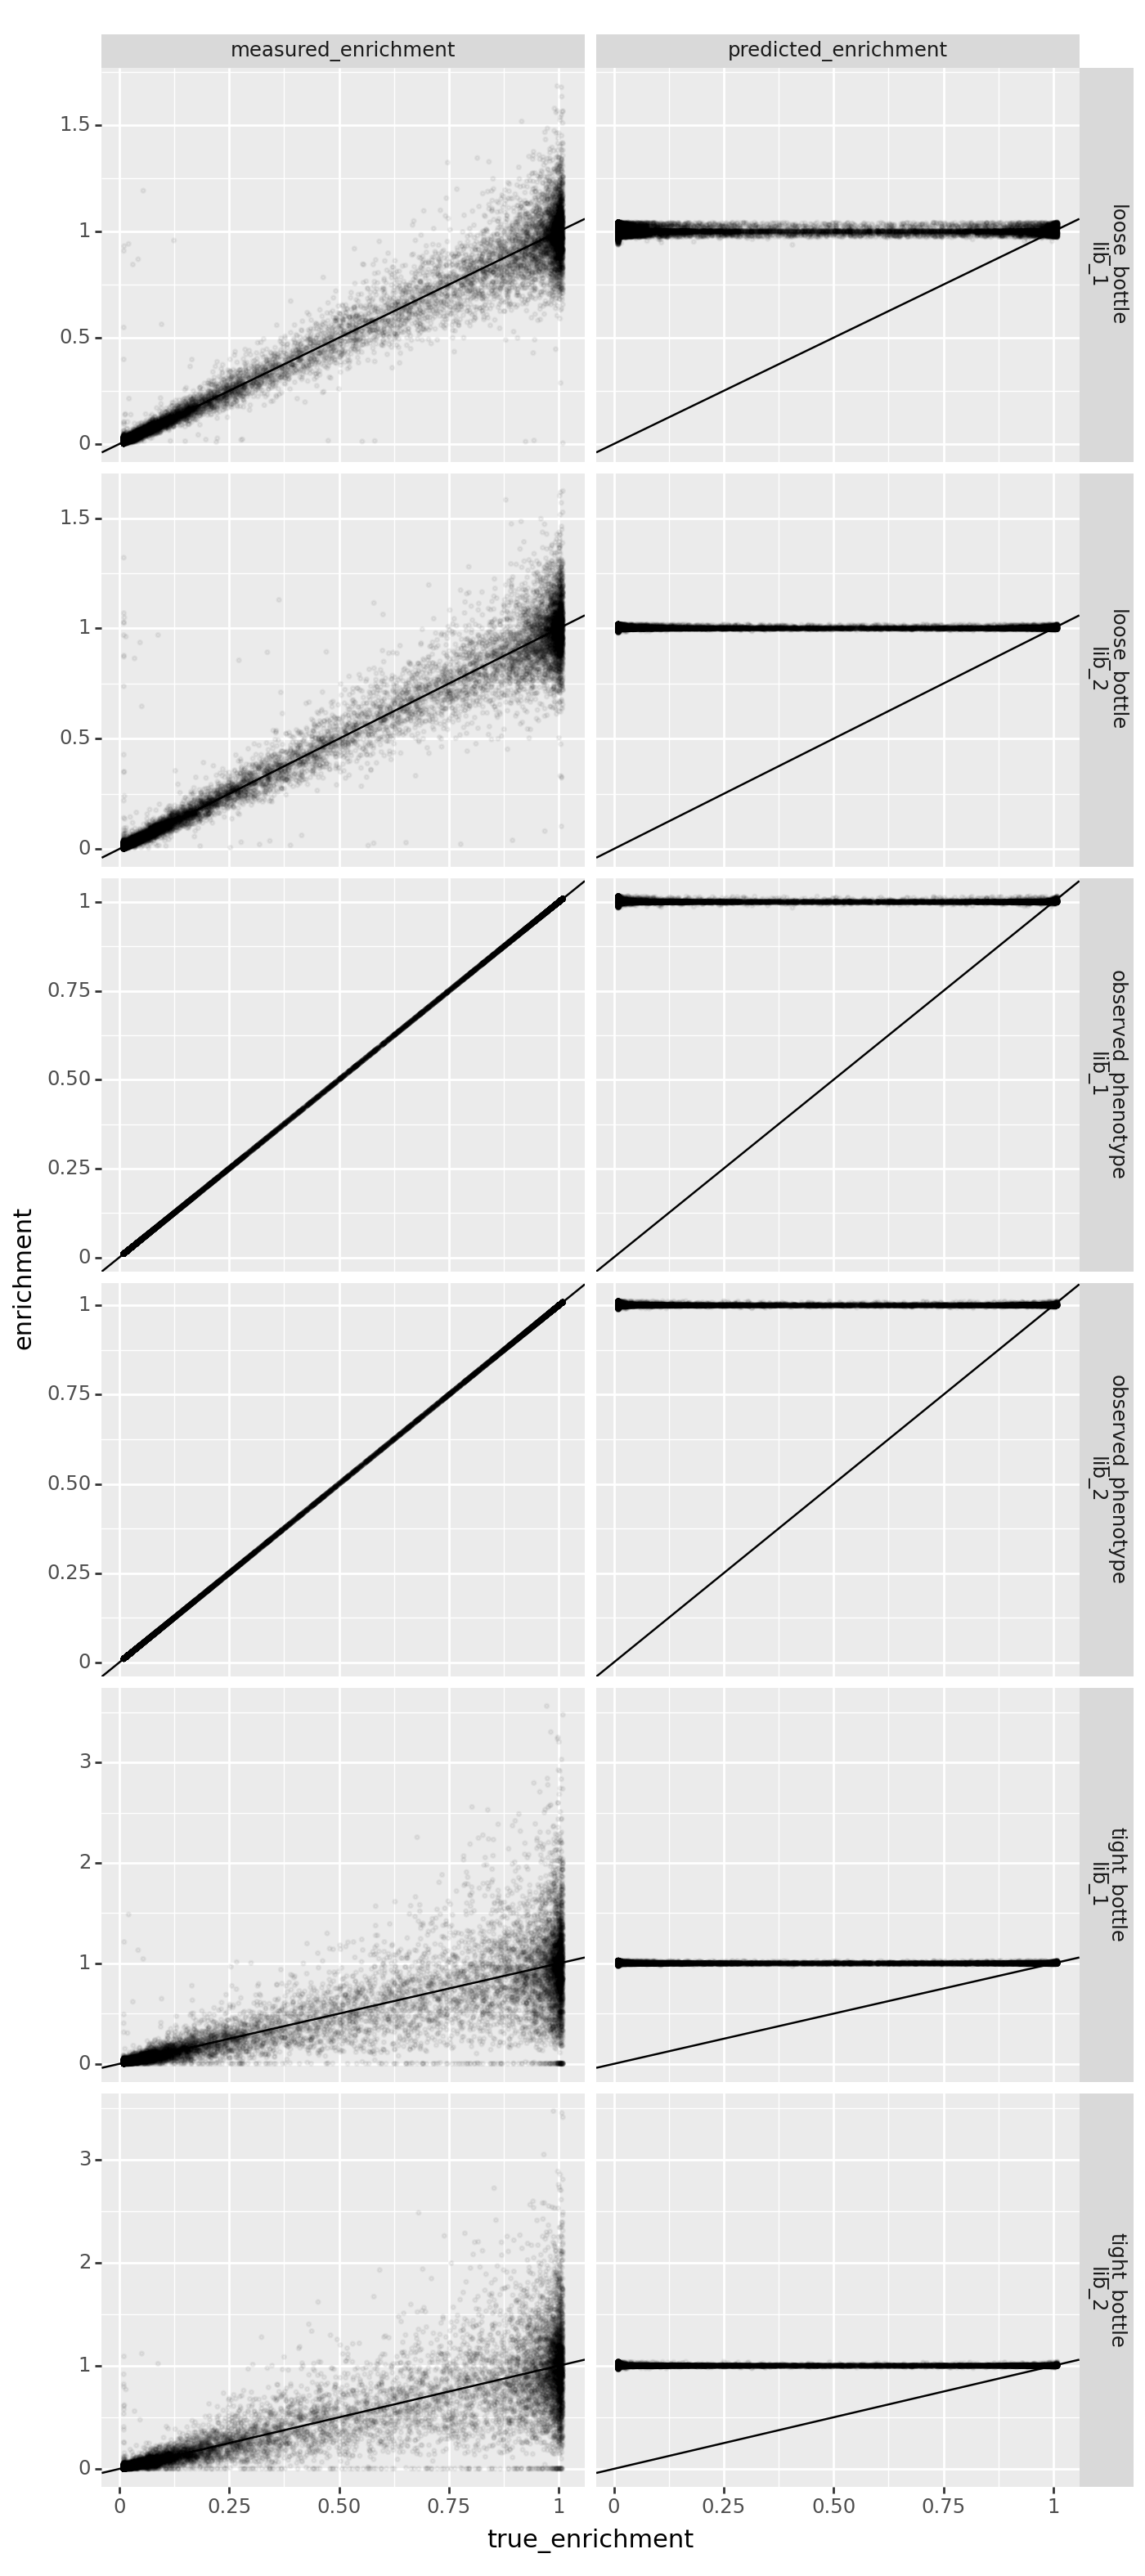

In [74]:
p = (
    ggplot(
        data.melt(
            # id_vars=["measurement_type", "library", "condition", "true_enrichment"],
            id_vars=["measurement_type", "library", "true_enrichment"],
            value_vars=["predicted_enrichment", "measured_enrichment"],
            var_name="enrichment_type",
            value_name="enrichment",
        ),
        # variants_df,
        aes("true_enrichment", "enrichment"),
    )
    + geom_abline(
        slope=1,
        intercept=0, 
        # alpha=0.5,
        # size=0.5,
    )
    + geom_point(alpha=0.05, size=0.5)
    # + facet_grid("measurement_type + library + condition ~ enrichment_type", scales="free_y")
    + facet_grid("measurement_type + library ~ enrichment_type", scales="free_y")
    + theme(
        figure_size=(
            7,
            2.75 * (variants_df["measurement_type"].nunique() + variants_df["library"].nunique()) + variants_df["condition"].nunique(),
        )
    )
)

_ = p.draw(show=True)

Next, let's take a look at the inferred shift parameters for each of the libraries.

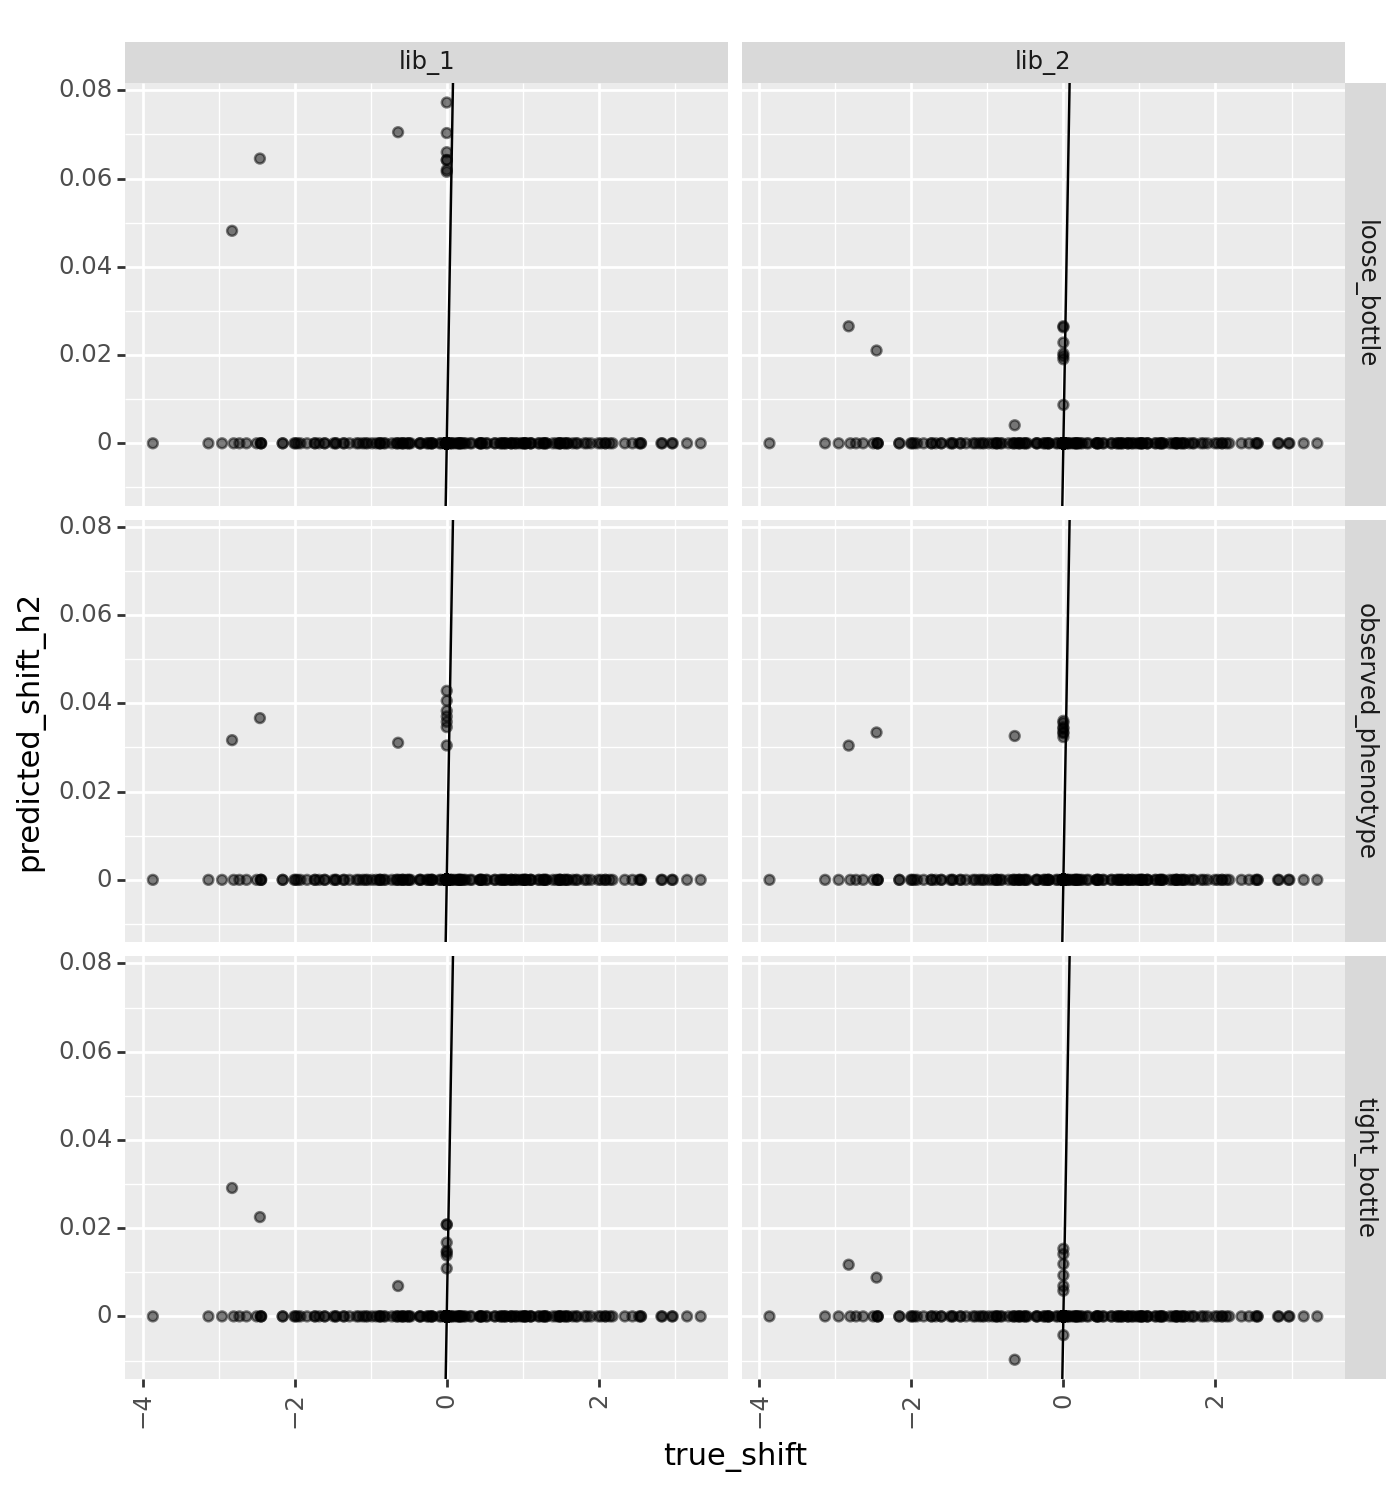

In [76]:
# plot correlations of true and predicted shifts
for (x, y) in itertools.combinations(
    ["true_shift", "predicted_shift_h2"], 2
):
    p = (
        # ggplot(mutations_df.query("lasso == 1e-05"))
        ggplot(mutations_df.query(f"scale_coeff_lasso_shift == {lasso}"))
        + geom_point(
            aes(
                x=x,
                y=y    
            ),
            alpha=0.5,
            # size=0.5,
        )
        + geom_abline(
            slope=1,
            intercept=0, 
            # alpha=0.5,
            # size=0.5,
        )
        + ylab(y)
        + xlab(x)
        + facet_grid("measurement_type ~ library")
        + theme(
            figure_size=(7 , 7.5),
            axis_text_x=element_text(angle=90),
            # panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        # + scale_fill_manual(values=variant_class_color)
        # + scale_alpha_manual(values=variant_class_alpha)
    )
    _ = p.draw(show=True)

In [77]:
fit_collection.query("scale_coeff_lasso_shift == 2e-4 & library == 'lib_1' & measurement_type == 'loose_bottle'")

model                   dataset_name  \
5  Model(Model-2)  lib_1_loose_bottle_func_score   

                                 step_loss epistatic_model output_activation  \
5  [7.752899505850369, 3.0102483057348595]         Sigmoid          Identity   

  scale_coeff_lasso_shift scale_coeff_ridge_beta scale_coeff_ridge_shift  \
5                  0.0002                      0                       0   

  scale_coeff_ridge_gamma scale_coeff_ridge_alpha_d  ... num_training_steps  \
5                       0                         0  ...                  1   

  iterations_per_step n_hidden_units lower_bound PRNGKey measurement_type  \
5                 100              5        None       0     loose_bottle   

  library variant_phenotype_corr beta_corr shift_corr  
5   lib_1               0.007853  0.007813   -0.04809  

[1 rows x 26 columns]

In [78]:
fit_collection.loc[5, "model"].mut_param_heatmap()

alt.VConcatChart(...)

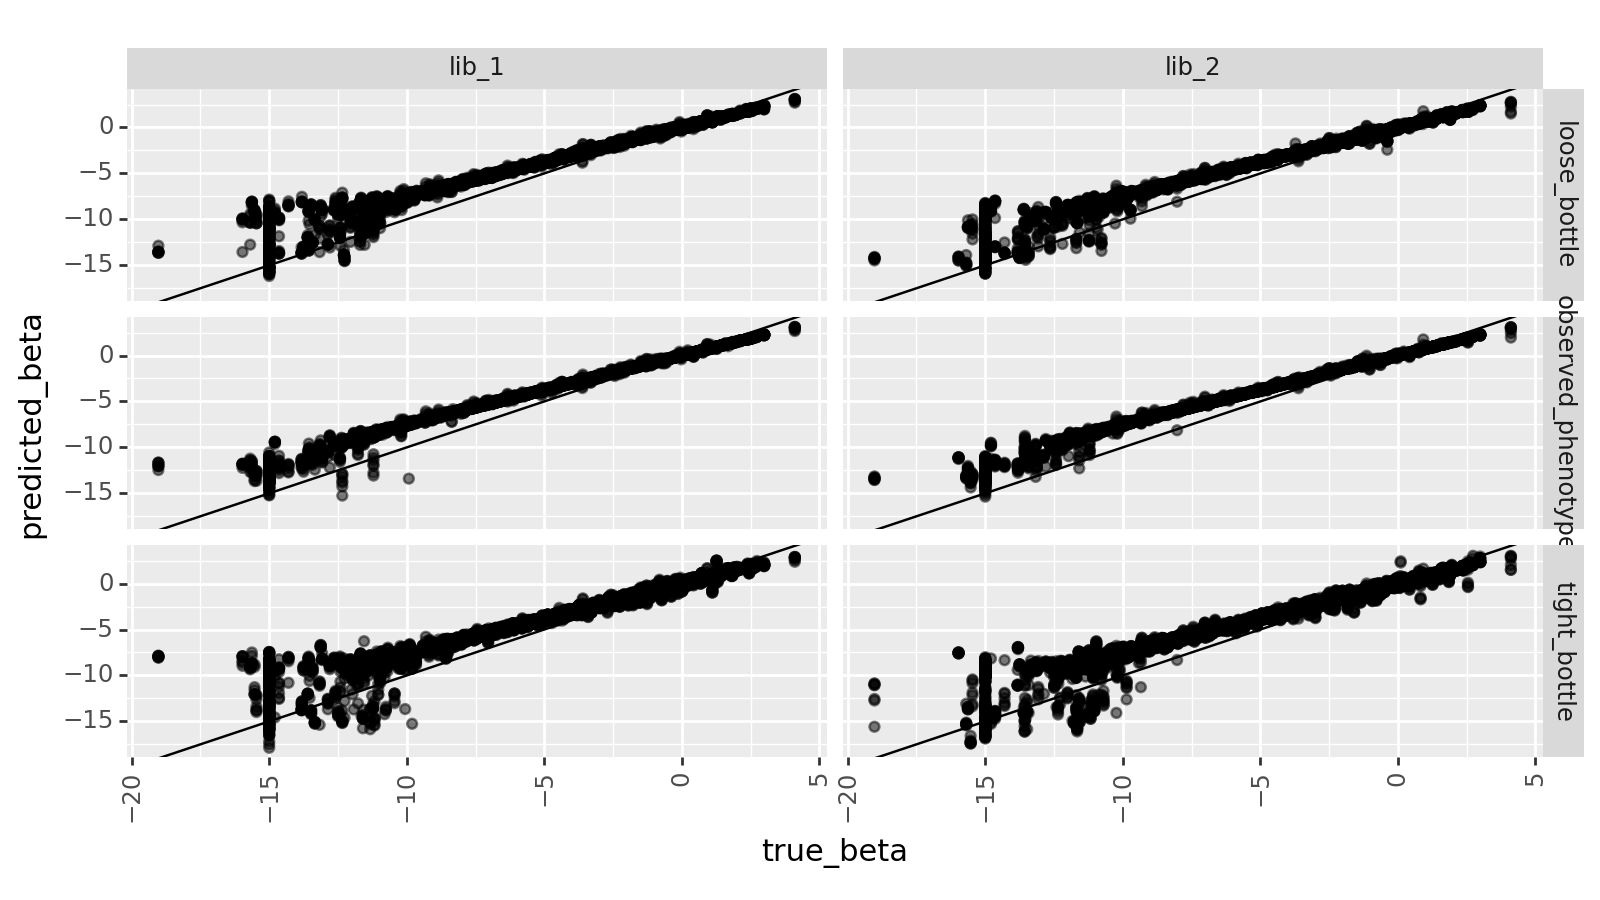

In [64]:
 # plot correlations of true and predicted shifts
for (x, y) in itertools.combinations(
    ["true_beta", "predicted_beta"], 2
):
    p = (
        ggplot(mutations_df)
        + geom_point(
            aes(
                x=x,
                y=y    
            ),
            alpha=0.5,
            # size=0.5,
        )
        + geom_abline(
            slope=1,
            intercept=0, 
            # alpha=0.5,
        )
        + ylab(y)
        + xlab(x)
        + facet_grid("measurement_type ~ library")
        + theme(
            figure_size=(4 * len(libs), 2.25 * len(bottlenecks)),
            axis_text_x=element_text(angle=90),
            # panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        # + scale_fill_manual(values=variant_class_color)
        # + scale_alpha_manual(values=variant_class_alpha)
    )
    _ = p.draw(show=True)